***USED FOR ANALYSIS OF TRANSCRIPTION***

**TO DO** 

- Remove filler words and do csv analysis.
- Find which words come in as replacement and make graphs
- What to do with gaap and EBITDA

In [ ]:
import os
from jiwer import wer, mer, wil, compute_measures
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as mtick
import seaborn as sns
import re
import numpy as np
import pandas as pd
from rapidfuzz import fuzz, process
import warnings
from pathlib import Path
from matplotlib.patches import Patch
from difflib import SequenceMatcher
from rapidfuzz.distance import Levenshtein

import unicodedata
from scipy.stats import f_oneway
import random

In [2]:
def is_latin_char(ch): # Check if a character is Latin or a digit to avoid foreign
    name = unicodedata.name(ch, '')
    return 'LATIN' in name or ch.isdigit() or ch.isspace() or ch in "_"

def clean_and_tokenize(text):
    text = text.lower()
    # Remove possessive 's after numbers like 2021's → 2021
    text = re.sub(r"(?<=\d)'s\b", "", text)
    #Replace - with space
    text = text.replace('-', ' ')
    # Protect decimals (e.g. 2.4 → 2__DOT__4)
    text = re.sub(r'(?<=\d)\.(?=\d)', '__DOT__', text)
    text = ''.join(ch for ch in text if is_latin_char(ch))
    # Restore decimals
    text = text.replace('__DOT__', '.')

    return text.split()

def read_txt_file(path):
    with open(path, 'r', encoding='utf-8') as f:
        return f.read().strip()

def get_transcript_variants(root_folder, suffixes):
    all_pairs = []
    for subdir in os.listdir(root_folder):
        full_path = os.path.join(root_folder, subdir)
        if os.path.isdir(full_path):
            files = os.listdir(full_path)
            gt_file = [f for f in files if f.endswith('.txt') and not any(f.endswith(suffix) for suffix in suffixes) and not f.endswith('_timing.txt')]
            if not gt_file:
                continue
            gt_path = os.path.join(full_path, gt_file[0])
            for suffix in suffixes:
                hyp_file = [f for f in files if f == f"{subdir}{suffix}"]
                if hyp_file:
                    hyp_path = os.path.join(full_path, hyp_file[0])
                    all_pairs.append((subdir, suffix, gt_path, hyp_path))
    return all_pairs

def compute_metrics(gt_text, hyp_text):
    measures = compute_measures(gt_text, hyp_text)
    return {
        "wer": measures['wer'],
        "mer": measures['mer'],
        "wil": measures['wil']
    }

def evaluate_folder_variants(base_folder, suffixes):
    results = []
    rows = []
    pairs = get_transcript_variants(base_folder, suffixes)

    for folder_name, suffix, gt_path, hyp_path in pairs:
        gt = read_txt_file(gt_path)
        hyp = read_txt_file(hyp_path)
        gt_tokens = clean_and_tokenize(gt)
        hyp_tokens = clean_and_tokenize(hyp)
        gt_clean = ' '.join(gt_tokens)
        hyp_clean = ' '.join(hyp_tokens)
        metrics = compute_metrics(gt_clean, hyp_clean)

        results.append({
            "folder": folder_name,
            "variant": variant_name_map[suffix],
            "wer": metrics["wer"],
            "mer": metrics["mer"],
            "wil": metrics["wil"]
        })
        rows.append({
            "folder": folder_name,
            "variant": variant_name_map[suffix],
            "gt_path": gt_path,
            "hyp_path": hyp_path,
            "gt_text": gt_clean,
            "hyp_text": hyp_clean,
            "gt_word_count": len(gt_tokens),
            "hyp_word_count": len(hyp_tokens)
        })

    df_metrics = pd.DataFrame(results)
    df_paths = pd.DataFrame(rows)

    # Total word count printout
    summary = df_paths.groupby("variant")[["gt_word_count", "hyp_word_count"]].sum()
    print(f"\n{base_folder} — Total word counts:")
    print(summary)

    return df_metrics, df_paths


variant_name_map = {
    '_Whisper.txt': 'whisper-small',
    '_Turbo_Whisper.txt': 'whisper-large-v3-turbo',
    '_openai_transcript.txt': 'GPT-4o mini Transcribe'
}

suffixes = ['_Whisper.txt', '_openai_transcript.txt', '_Turbo_Whisper.txt']
df_21, df_paths_21 = evaluate_folder_variants('Data/combined_21', suffixes)
print("Combined 21 summary:")
print(df_21.groupby("variant").describe())

df_22, df_paths_22 = evaluate_folder_variants('Data/combined_22', suffixes)
print("\nCombined 22 summary:")
print(df_22.groupby("variant").describe())


Data/combined_21 — Total word counts:
                        gt_word_count  hyp_word_count
variant                                              
GPT-4o mini Transcribe         364074          338038
whisper-large-v3-turbo         364074          345377
whisper-small                  364074          345946
Combined 21 summary:
                         wer                                          \
                       count      mean       std       min       25%   
variant                                                                
GPT-4o mini Transcribe  44.0  0.130032  0.041143  0.066328  0.101971   
whisper-large-v3-turbo  44.0  0.130932  0.041245  0.059085  0.105611   
whisper-small           44.0  0.158218  0.045551  0.103009  0.129052   

                                                       mer            ...  \
                             50%       75%       max count      mean  ...   
variant                                                               ...   
GPT-4o

In [3]:
percent_per_variant = (
    df_22.assign(over_50=df_22['wer'] > 0.4)
         .groupby("variant")['over_50']
         .mean() * 100
)

print("Percentage of files with WER > 40%:")
print(percent_per_variant.round(1))


Percentage of files with WER > 40%:
variant
GPT-4o mini Transcribe    4.0
whisper-large-v3-turbo    1.6
whisper-small             3.2
Name: over_50, dtype: float64


In [4]:
# Step 1: Combine all metrics and paths
df_all = pd.concat([df_21, df_22], ignore_index=True)
df_paths_all = pd.concat([df_paths_21, df_paths_22], ignore_index=True)
df_full = pd.merge(df_all, df_paths_all, on=['folder', 'variant'], how='left')

# Step 2: Compute average WER per folder
avg_wer_per_folder = (
    df_full.groupby("folder")['wer']
    .mean()
    .reset_index(name='avg_wer')
)

# Step 3: Get top 3 folders with highest average WER
top_3_folders = avg_wer_per_folder.nlargest(3, 'avg_wer')['folder'].tolist()

# Step 4: Get all rows for those top 3 folders
top_3_details = df_full[df_full['folder'].isin(top_3_folders)]

# Step 5: Print nicely
print("Top 3 folders with highest average WER across variants:\n")
for folder in top_3_folders:
    folder_df = top_3_details[top_3_details['folder'] == folder]
    avg = folder_df['wer'].mean()
    print(f"Folder: {folder} (Avg WER: {avg:.2f})")
    for _, row in folder_df.iterrows():
        print(f"  Variant: {row['variant']}")
        print(f"    WER: {row['wer']:.2f}")
        print(f"    GT Path: {row['gt_path']}")
        print(f"    Hyp Path: {row['hyp_path']}")
    print()


Top 3 folders with highest average WER across variants:

Folder: 4453076 (Avg WER: 0.73)
  Variant: whisper-small
    WER: 0.77
    GT Path: Data/combined_22\4453076\4453076.txt
    Hyp Path: Data/combined_22\4453076\4453076_Whisper.txt
  Variant: GPT-4o mini Transcribe
    WER: 0.73
    GT Path: Data/combined_22\4453076\4453076.txt
    Hyp Path: Data/combined_22\4453076\4453076_openai_transcript.txt
  Variant: whisper-large-v3-turbo
    WER: 0.69
    GT Path: Data/combined_22\4453076\4453076.txt
    Hyp Path: Data/combined_22\4453076\4453076_Turbo_Whisper.txt

Folder: 4481766 (Avg WER: 0.50)
  Variant: whisper-small
    WER: 0.61
    GT Path: Data/combined_22\4481766\4481766.txt
    Hyp Path: Data/combined_22\4481766\4481766_Whisper.txt
  Variant: GPT-4o mini Transcribe
    WER: 0.41
    GT Path: Data/combined_22\4481766\4481766.txt
    Hyp Path: Data/combined_22\4481766\4481766_openai_transcript.txt
  Variant: whisper-large-v3-turbo
    WER: 0.47
    GT Path: Data/combined_22\4481766


=== WER Means by Variant and Source ===
GPT-4o mini Transcribe         | Earnings21   → Mean WER: 0.130
GPT-4o mini Transcribe         | Earnings22   → Mean WER: 0.180
whisper-large-v3-turbo         | Earnings21   → Mean WER: 0.131
whisper-large-v3-turbo         | Earnings22   → Mean WER: 0.186
whisper-small                  | Earnings21   → Mean WER: 0.158
whisper-small                  | Earnings22   → Mean WER: 0.219

=== MER Means by Variant and Source ===
GPT-4o mini Transcribe         | Earnings21   → Mean MER: 0.128
GPT-4o mini Transcribe         | Earnings22   → Mean MER: 0.176
whisper-large-v3-turbo         | Earnings21   → Mean MER: 0.128
whisper-large-v3-turbo         | Earnings22   → Mean MER: 0.178
whisper-small                  | Earnings21   → Mean MER: 0.154
whisper-small                  | Earnings22   → Mean MER: 0.206

=== WIL Means by Variant and Source ===
GPT-4o mini Transcribe         | Earnings21   → Mean WIL: 0.166
GPT-4o mini Transcribe         | Earnings22  

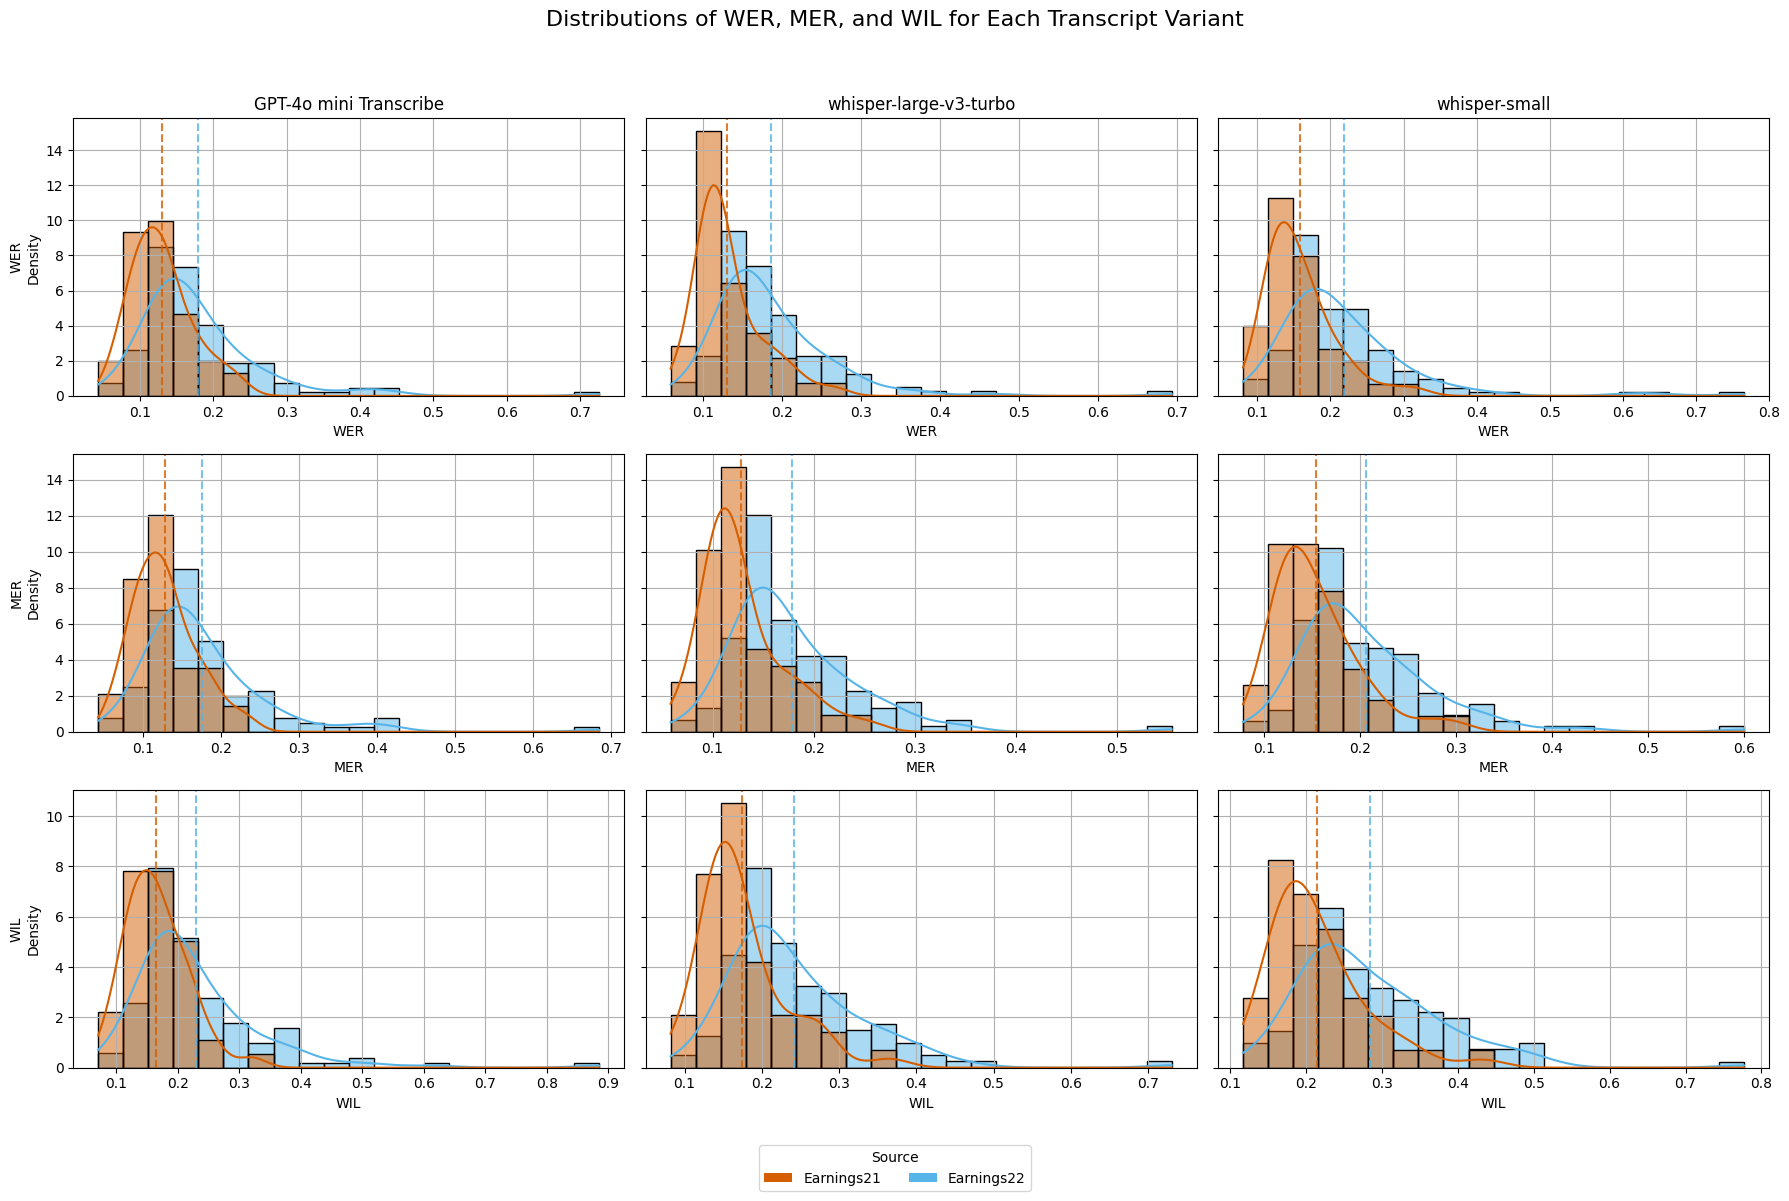

In [5]:
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")
# Add 'source' column and combine
df_21['source'] = 'combined_21'
df_22['source'] = 'combined_22'
df_combined = pd.concat([df_21, df_22], ignore_index=True)

# Melt for boxplot
df_melted = df_combined.melt(
    id_vars=['folder', 'source', 'variant'],
    value_vars=['wer', 'mer', 'wil'],
    var_name='metric',
    value_name='value'
)

palette = {
    "combined_21": "#D55E00",
    "combined_22": "#56B4E9"
}

legend_label_map = {
    "combined_21": "Earnings21",
    "combined_22": "Earnings22"
}

variants = sorted(df_combined['variant'].unique())
metrics = ['wer', 'mer', 'wil']

# === Combined 3x3 figure ===
fig, axes = plt.subplots(3, 3, figsize=(18, 12), sharey='row')

for row, metric in enumerate(metrics):
    print(f"\n=== {metric.upper()} Means by Variant and Source ===")

    for col, variant in enumerate(variants):
        ax = axes[row][col]
        df_variant = df_combined[df_combined['variant'] == variant]

        # Histogram with KDE
        sns.histplot(
            data=df_variant,
            x=metric,
            hue='source',
            palette=palette,
            kde=True,
            bins=20,
            stat='density',
            common_norm=False,
            ax=ax,
            legend=False
        )

        # Add vertical mean lines and print
        for source in df_variant['source'].unique():
            source_df = df_variant[df_variant['source'] == source]
            mean_val = source_df[metric].mean()
            color = palette[source]

            # Print to console
            print(f"{variant:30} | {legend_label_map[source]:12} → Mean {metric.upper()}: {mean_val:.3f}")

            ax.axvline(mean_val, linestyle='--', color=color, linewidth=1.5, alpha=0.8)

        # Titles and labels
        if row == 0:
            ax.set_title(f"{variant}", fontsize=12)
        if col == 0:
            ax.set_ylabel(f"{metric.upper()}\nDensity", fontsize=10)
        else:
            ax.set_ylabel("")
        ax.set_xlabel(metric.upper())
        ax.grid(True)

# === Add shared legend with renamed labels ===
legend_elements = [
    Patch(facecolor=palette["combined_21"], label="Earnings21"),
    Patch(facecolor=palette["combined_22"], label="Earnings22")
]
fig.legend(
    handles=legend_elements,
    loc='lower center',
    ncol=2,
    bbox_to_anchor=(0.5, -0.01),
    frameon=True,
    title="Source"
)

fig.suptitle("Distributions of WER, MER, and WIL for Each Transcript Variant", fontsize=16)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()


I want to find filler words that are only in the ground truth but not the transcripts


C:\Users\mark.welin\AppData\Local\Temp\ipykernel_13668\761684405.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='rel_diff', y='word',palette=df_plot.set_index('word').loc[df_plot['word'], 'color'].to_dict(),ax=ax,order=filter_words if filter_words else None)
C:\Users\mark.welin\AppData\Local\Temp\ipykernel_13668\761684405.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='rel_diff', y='word',palette=df_plot.set_index('word').loc[df_plot['word'], 'color'].to_dict(),ax=ax,order=filter_words if filter_words else None)
C:\Users\mark.welin\AppData\Local\Temp\ipykernel_13668\761684405.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is de

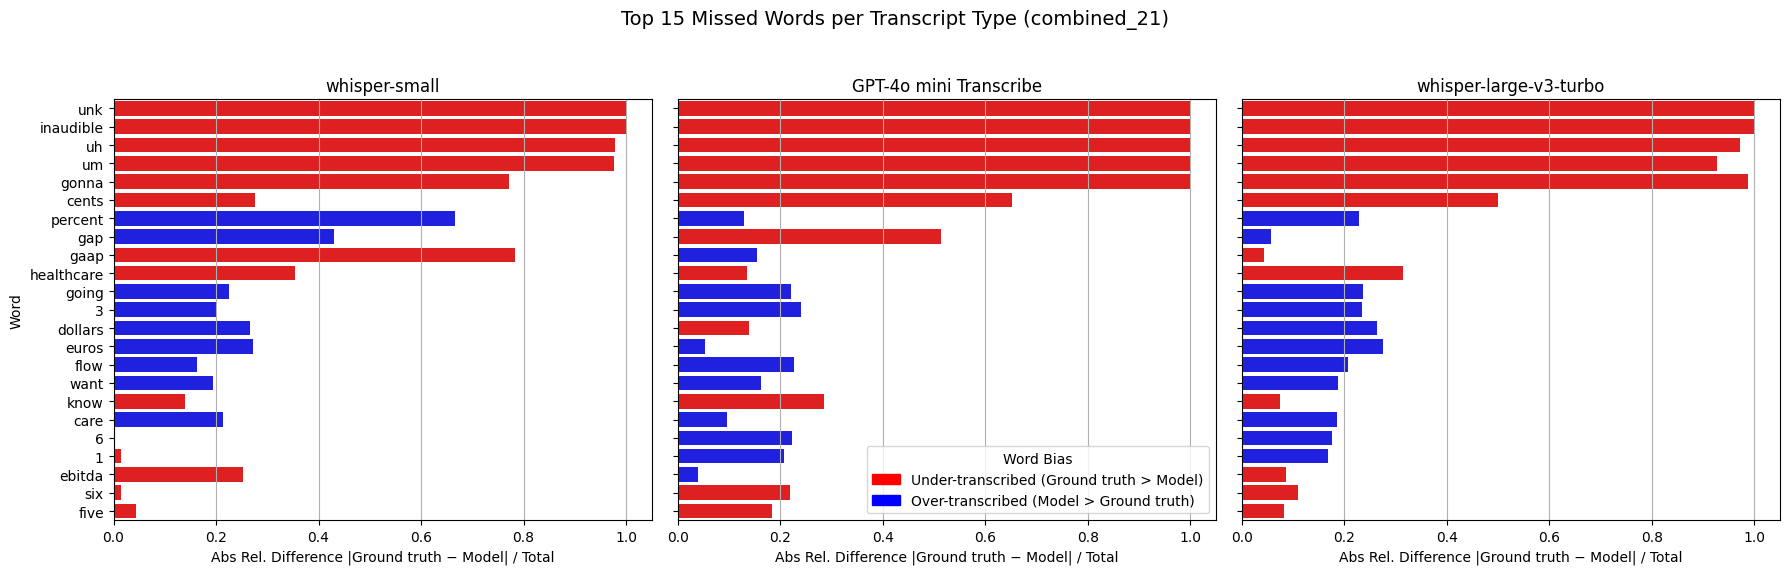

C:\Users\mark.welin\AppData\Local\Temp\ipykernel_13668\761684405.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='rel_diff', y='word',palette=df_plot.set_index('word').loc[df_plot['word'], 'color'].to_dict(),ax=ax,order=filter_words if filter_words else None)
C:\Users\mark.welin\AppData\Local\Temp\ipykernel_13668\761684405.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='rel_diff', y='word',palette=df_plot.set_index('word').loc[df_plot['word'], 'color'].to_dict(),ax=ax,order=filter_words if filter_words else None)
C:\Users\mark.welin\AppData\Local\Temp\ipykernel_13668\761684405.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is de

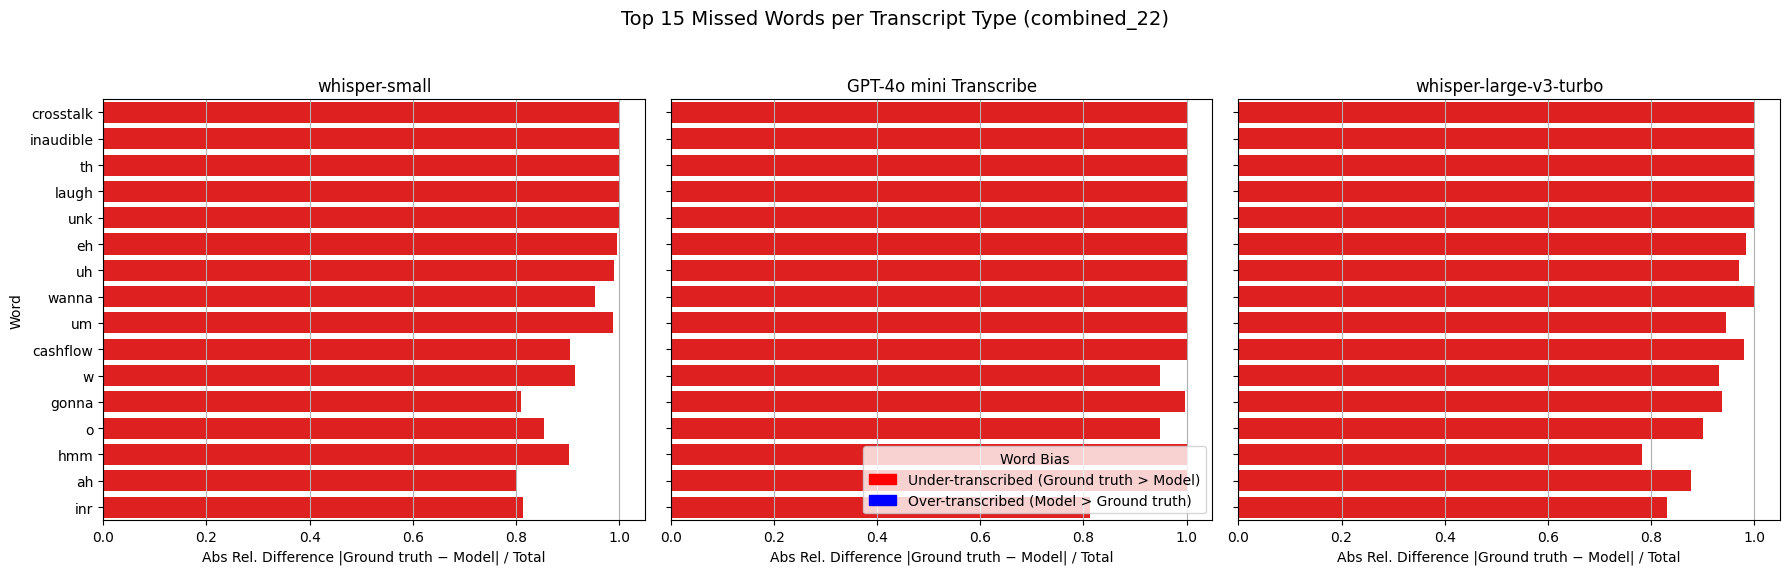

In [6]:
min_total = 100
def get_top_missed_words_by_variant(df_paths, label='', top_n=15, plot=True, filter_words=None):
    variants = df_paths['variant'].unique()
    fig, axes = plt.subplots(1, len(variants), figsize=(6 * len(variants), 6), sharey=True) if plot else (None, [None] * len(variants))
    if len(variants) == 1:
        axes = [axes]  

    all_top_words = []
    for i, (ax, variant) in enumerate(zip(axes, variants)):
        df_var = df_paths[df_paths['variant'] == variant]
        gt_words = []
        hyp_words = []

        for _, row in df_var.iterrows():
            gt_words += row['gt_text'].split()
            hyp_words += row['hyp_text'].split()

        gt_counter = Counter(gt_words)
        hyp_counter = Counter(hyp_words)
        all_words = set(gt_counter) | set(hyp_counter)

        data = []
        for word in all_words:
            gt_count = gt_counter[word]
            hyp_count = hyp_counter[word]
            total = gt_count + hyp_count
            color = 'red' if gt_count > hyp_count else 'blue'
            rel_diff = abs((gt_count - hyp_count)) / total
            data.append({
                'variant': variant,
                'word': word,
                'gt_count': gt_count,
                'hyp_count': hyp_count,
                'rel_diff': rel_diff,
                'total': total,
                'top' : False,
                'color': color
            })

        df_diff = pd.DataFrame(data)
        df_top = df_diff[df_diff['total'] > min_total].sort_values(by='rel_diff', ascending=False).head(top_n)
        df_diff['top'] = df_diff['word'].isin(df_top['word'])
        all_top_words.append(df_diff)
        if plot:
            if filter_words is not None:
                df_plot = df_diff[df_diff['word'].isin(filter_words)]
            else:
                df_plot = df_diff.sort_values(by='rel_diff', ascending=False).head(top_n)
            sns.barplot(data=df_plot, x='rel_diff', y='word',palette=df_plot.set_index('word').loc[df_plot['word'], 'color'].to_dict(),ax=ax,order=filter_words if filter_words else None)
            if i == 1:  # Only show legend on the middle plot
                legend_handles = [Patch(color='red', label='Under-transcribed (Ground truth > Model)'), Patch(color='blue', label='Over-transcribed (Model > Ground truth)')]
                ax.legend(handles=legend_handles, title='Word Bias', loc='lower right')
            ax.set_title(f"{variant}")
            ax.set_xlabel("Abs Rel. Difference |Ground truth − Model| / Total")
            ax.set_ylabel("Word")
            ax.grid(True, axis='x')

    if plot:
        plt.suptitle(f"Top {top_n} Missed Words per Transcript Type ({label})", fontsize=14)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
        return

    return pd.concat(all_top_words, ignore_index=True)




# First run: collect all data (no plots)
df_all_21 = get_top_missed_words_by_variant(df_paths_21, label='combined_21', plot=False)
df_all_22 = get_top_missed_words_by_variant(df_paths_22, label='combined_22', plot=False)

top_words_21 = df_all_21[(df_all_21['total'] > min_total) & (df_all_21['top'])]['word'].unique()
top_words_22 = df_all_22[(df_all_22['total'] > min_total) & (df_all_22['top'])]['word'].unique()

ordered_words_21 = (
    df_all_21[df_all_21['word'].isin(top_words_21)]
    .groupby('word', as_index=False)
    .agg({'rel_diff': 'mean'})
    .sort_values(by='rel_diff', ascending=False)
)
ordered_words_22 = (
    df_all_22[df_all_22['word'].isin(top_words_22)]
    .groupby('word', as_index=False)
    .agg({'rel_diff': 'mean'})
    .sort_values(by='rel_diff', ascending=False)
)
ordered_words_21 = ordered_words_21['word'].tolist()
ordered_words_22 = ordered_words_22['word'].tolist()

get_top_missed_words_by_variant(df_paths_21, label='combined_21', plot=True, filter_words=ordered_words_21)
get_top_missed_words_by_variant(df_paths_22, label='combined_22', plot=True, filter_words=ordered_words_22)


There are words here that are obviously not real words being said. Words like "unk", "inaudible", "crosstalk" but also filler words that the transcription model ignores "uh" and "um". To get a more accurate reading of our date we're going to ommit these words from our analysis.

Here we see the issues that can arrise with transcription in general. When a human sits and transcribes something, they have a lot of choices to make. Whether to informally abbreviate phrases like "wanna" and "gonna", whether to include filler words and if so, where to include them, what to do if a word is inaudible or unknown, what to do when people are speaking over each other etc. To get a more accurate understanding of how well our transcription model is doing, we will clean some of the ground truth data up by doing the following:

- Removing following filler words/sounds: "eh", "uh", "um", "w", "th", "mmhmm", "hmm", "ah", "y".

- Removing descriptive words: "unk", "inaudible" and "crosstalk" 

-  Altering: Cashflow to Cash flow, Gonna to Going to, Wanna to Want to, Health care to healthcare



In [88]:
# Define substitutions and fillers
SUBSTITUTIONS = {
    "gonna": ["going", "to"],
    "wanna": ["want", "to"],
    "gotta": ["got", "to"],
    "qoq:": ["q", "o", "q"],
    "kinda": ["kind", "of"],
    "cashflow": ["cash", "flow"],
    "yearoveryear": ["year", "over", "year"],
    "yearonyear": ["year", "on", "year"],
    "s": ["is"],
    "forwardlooking": ["forward", "looking"],
    "one": ["1"],
    "two": ["2"],
    "three": ["3"],
    "four": ["4"],
    "breakeven": ["break", "even"],
    "five": ["5"],
    "six": ["6"],
    "seven": ["7"],
    "eight": ["8"],
    "nine": ["9"],
    "hundred": ["100"],
    "sixteen": ["16"],
    "fifty": ["50"],
    "ninety": ["90"],
    "hundred": ["100"],
    "followup": ["follow", "up"],
    "longterm": ["long", "term"],
    "shortterm": ["short", "term"],
    "healthcare": ["health", "care"],
    "singledigit": ["single", "digit"],
    "doubledigit": ["double", "digit"],
    "midsingledigit": ["mid", "single", "digit"],
    "midsingle" : ["mid", "single"],
    "sugarcane": ["sugar", "cane"]
}
FILLERS = {"eh", "o", "uh", "um", "w", "th", "mmhmm", "hmm", "em", "ah", "e", "y", "inaudible", "unk", "crosstalk", "laugh", "oh", "affirmative", "q", "gaap", "gap", "percent"}

PREFIX_SPLITS = {"non", "pre", "one"}



def apply_substitutions(tokens):
    output = []

    for token in tokens:
        split_parts = None
        for prefix in PREFIX_SPLITS:
            if token.startswith(prefix) and len(token) > len(prefix):
                split_parts = [prefix, token[len(prefix):]]
                break

        parts = split_parts if split_parts else [token]

        # apply substitutions to each part
        for part in parts:
            output.extend(SUBSTITUTIONS.get(part, [part]))

    return output

def evaluate_cleaned_variants(base_folder, suffixes):
    results = []
    rows = []
    pairs = get_transcript_variants(base_folder, suffixes)

    for folder_name, suffix, gt_path, hyp_path in pairs:
        gt = read_txt_file(gt_path)
        hyp = read_txt_file(hyp_path)
        
        gt_words = apply_substitutions(clean_and_tokenize(gt))
        hyp_words = apply_substitutions(clean_and_tokenize(hyp))

        gt_filler_count = sum(word in FILLERS for word in gt_words)
        hyp_filler_count = sum(word in FILLERS for word in hyp_words)

        gt_cleaned = [w for w in gt_words if w not in FILLERS]
        hyp_cleaned = [w for w in hyp_words if w not in FILLERS]

        metrics = compute_metrics(' '.join(gt_cleaned), ' '.join(hyp_cleaned))
        variant = suffix.replace('.txt', '').replace('_', '')

        results.append({
            "folder": folder_name,
            "variant": variant_name_map[suffix],
            "wer": metrics["wer"],
            "mer": metrics["mer"],
            "wil": metrics["wil"]
        })
        rows.append({
            "folder": folder_name,
            "variant": variant_name_map[suffix],
            "gt_path": gt_path,
            "hyp_path": hyp_path,
            "gt_word_count": len(gt_words),
            "gt_filler_count": gt_filler_count,
            "gt_word_count_clean": len(gt_cleaned),
            "hyp_word_count": len(hyp_words),
            "hyp_filler_count": hyp_filler_count,
            "hyp_word_count_clean": len(hyp_cleaned),
            "gt_text": ' '.join(gt_cleaned),        
            "hyp_text": ' '.join(hyp_cleaned)   
        })

    df_metrics = pd.DataFrame(results)
    df_paths = pd.DataFrame(rows)

    print(f"\n{base_folder} —")
    print(df_paths.groupby("variant")[["gt_word_count", "gt_filler_count", "hyp_word_count", "hyp_filler_count"]].sum())
    return df_metrics, df_paths

# Run on all variants
suffixes = ['_Whisper.txt', '_Turbo_Whisper.txt', '_openai_transcript.txt']
df_21, df_paths_21 = evaluate_cleaned_variants("Data/combined_21", suffixes)
df_22, df_paths_22 = evaluate_cleaned_variants("Data/combined_22", suffixes)


Data/combined_21 —
                        gt_word_count  gt_filler_count  hyp_word_count  \
variant                                                                  
GPT-4o mini Transcribe         366016            11929          339401   
whisper-large-v3-turbo         366016            11929          346728   
whisper-small                  366016            11929          347338   

                        hyp_filler_count  
variant                                   
GPT-4o mini Transcribe               375  
whisper-large-v3-turbo               614  
whisper-small                        680  

Data/combined_22 —
                        gt_word_count  gt_filler_count  hyp_word_count  \
variant                                                                  
GPT-4o mini Transcribe        1012100            49990          921482   
whisper-large-v3-turbo        1012100            49990          954087   
whisper-small                 1012100            49990          962625   

   

In [89]:
metadata = pd.read_csv("metadata_22.csv")
metadata = metadata.rename(columns={"File ID": "folder"})

df_22 = df_22.merge(metadata, on="folder", how="left")

df_22 = df_22.rename(columns={"Language Family + Area Based": "Language Family"})

df_22 = df_22.merge(df_paths_22, on=["folder", "variant"], how="left")

In [90]:
percent_per_variant = (
    df_22.assign(over_50=df_22['wer'] > 0.4)
         .groupby("variant")['over_50']
         .mean() * 100
)

print("Percentage of files with WER > 40%:")
print(percent_per_variant.round(1))


Percentage of files with WER > 40%:
variant
GPT-4o mini Transcribe    1.6
whisper-large-v3-turbo    1.6
whisper-small             3.2
Name: over_50, dtype: float64



=== WER Means by Variant and Source ===
GPT-4o mini Transcribe         | Earnings21   → Mean WER: 0.102
GPT-4o mini Transcribe         | Earnings22   → Mean WER: 0.143
whisper-large-v3-turbo         | Earnings21   → Mean WER: 0.104
whisper-large-v3-turbo         | Earnings22   → Mean WER: 0.152
whisper-small                  | Earnings21   → Mean WER: 0.132
whisper-small                  | Earnings22   → Mean WER: 0.186

=== MER Means by Variant and Source ===
GPT-4o mini Transcribe         | Earnings21   → Mean MER: 0.100
GPT-4o mini Transcribe         | Earnings22   → Mean MER: 0.138
whisper-large-v3-turbo         | Earnings21   → Mean MER: 0.102
whisper-large-v3-turbo         | Earnings22   → Mean MER: 0.143
whisper-small                  | Earnings21   → Mean MER: 0.128
whisper-small                  | Earnings22   → Mean MER: 0.172

=== WIL Means by Variant and Source ===
GPT-4o mini Transcribe         | Earnings21   → Mean WIL: 0.133
GPT-4o mini Transcribe         | Earnings22  

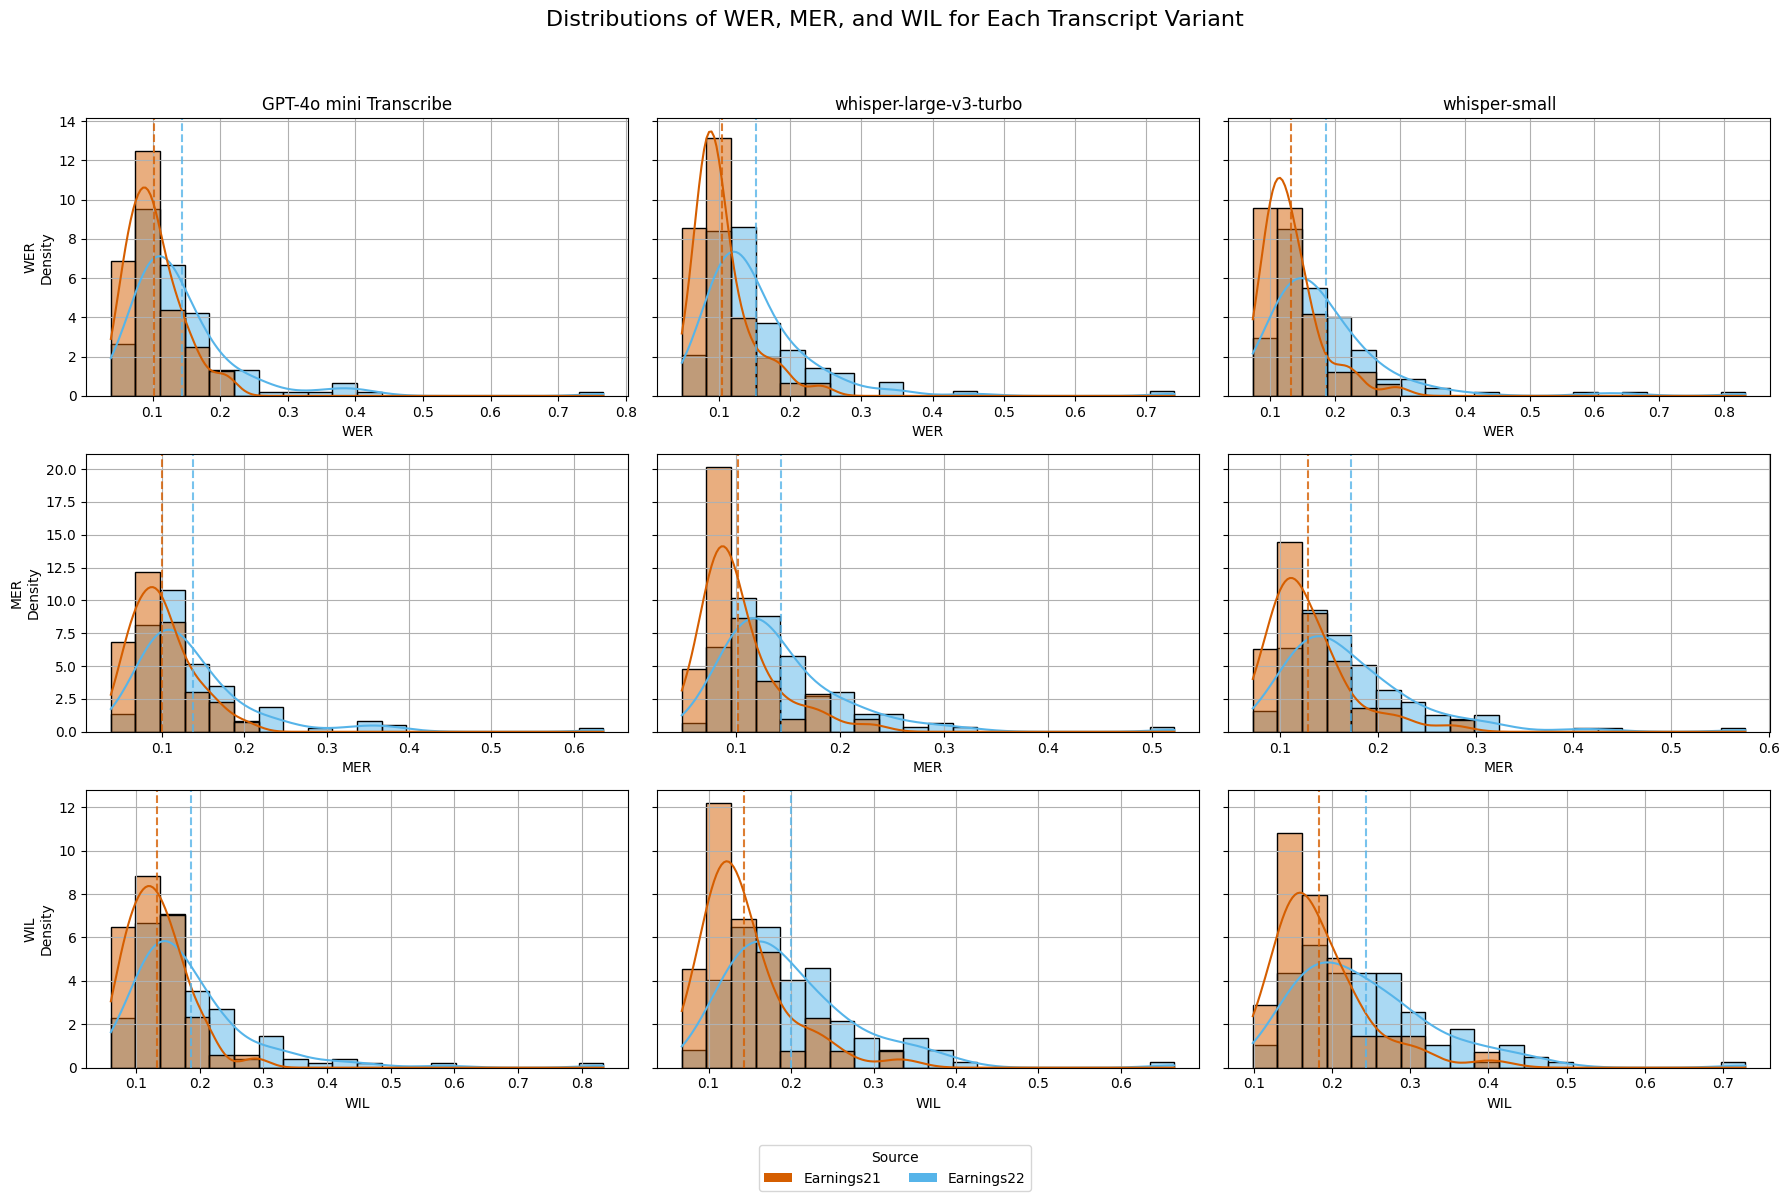

In [91]:
# Add 'source' column and combine
df_21['source'] = 'combined_21'
df_22['source'] = 'combined_22'
df_combined = pd.concat([df_21, df_22], ignore_index=True)

# Melt for boxplot
df_melted = df_combined.melt(
    id_vars=['folder', 'source', 'variant'],
    value_vars=['wer', 'mer', 'wil'],
    var_name='metric',
    value_name='value'
)

palette = {
    "combined_21": "#D55E00",
    "combined_22": "#56B4E9"
}

legend_label_map = {
    "combined_21": "Earnings21",
    "combined_22": "Earnings22"
}

variants = sorted(df_combined['variant'].unique())
metrics = ['wer', 'mer', 'wil']

# === Combined 3x3 figure ===
fig, axes = plt.subplots(3, 3, figsize=(18, 12), sharey='row')

for row, metric in enumerate(metrics):
    print(f"\n=== {metric.upper()} Means by Variant and Source ===")

    for col, variant in enumerate(variants):
        ax = axes[row][col]
        df_variant = df_combined[df_combined['variant'] == variant]

        # Histogram with KDE
        sns.histplot(
            data=df_variant,
            x=metric,
            hue='source',
            palette=palette,
            kde=True,
            bins=20,
            stat='density',
            common_norm=False,
            ax=ax,
            legend=False
        )

        # Add vertical mean lines and print
        for source in df_variant['source'].unique():
            source_df = df_variant[df_variant['source'] == source]
            mean_val = source_df[metric].mean()
            color = palette[source]

            # Print to console
            print(f"{variant:30} | {legend_label_map[source]:12} → Mean {metric.upper()}: {mean_val:.3f}")

            ax.axvline(mean_val, linestyle='--', color=color, linewidth=1.5, alpha=0.8)

        # Titles and labels
        if row == 0:
            ax.set_title(f"{variant}", fontsize=12)
        if col == 0:
            ax.set_ylabel(f"{metric.upper()}\nDensity", fontsize=10)
        else:
            ax.set_ylabel("")
        ax.set_xlabel(metric.upper())
        ax.grid(True)

# === Add shared legend with renamed labels ===
legend_elements = [
    Patch(facecolor=palette["combined_21"], label="Earnings21"),
    Patch(facecolor=palette["combined_22"], label="Earnings22")
]
fig.legend(
    handles=legend_elements,
    loc='lower center',
    ncol=2,
    bbox_to_anchor=(0.5, -0.01),
    frameon=True,
    title="Source"
)

fig.suptitle("Distributions of WER, MER, and WIL for Each Transcript Variant", fontsize=16)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()


In [92]:
# List of problematic folder IDs
bad_folders = [
    "4351517",
    "4453076",
    "4463693",
    "4481766",
    "4481967"
]

# Convert to string to ensure matching
bad_folders = list(map(str, bad_folders))

# Filter df_paths
df_paths_21 = df_paths_21[~df_paths_21['folder'].astype(str).isin(bad_folders)]
df_paths_22 = df_paths_22[~df_paths_22['folder'].astype(str).isin(bad_folders)]

# Filter df_21 and df_22 (model evaluation metrics)
df_21 = df_21[~df_21['folder'].astype(str).isin(bad_folders)]
df_22 = df_22[~df_22['folder'].astype(str).isin(bad_folders)]


C:\Users\mark.welin\AppData\Local\Temp\ipykernel_13668\357443000.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='rel_diff', y='word',palette=df_plot.set_index('word').loc[df_plot['word'], 'color'].to_dict(),ax=ax,order=filter_words if filter_words else None)
C:\Users\mark.welin\AppData\Local\Temp\ipykernel_13668\357443000.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='rel_diff', y='word',palette=df_plot.set_index('word').loc[df_plot['word'], 'color'].to_dict(),ax=ax,order=filter_words if filter_words else None)
C:\Users\mark.welin\AppData\Local\Temp\ipykernel_13668\357443000.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is de

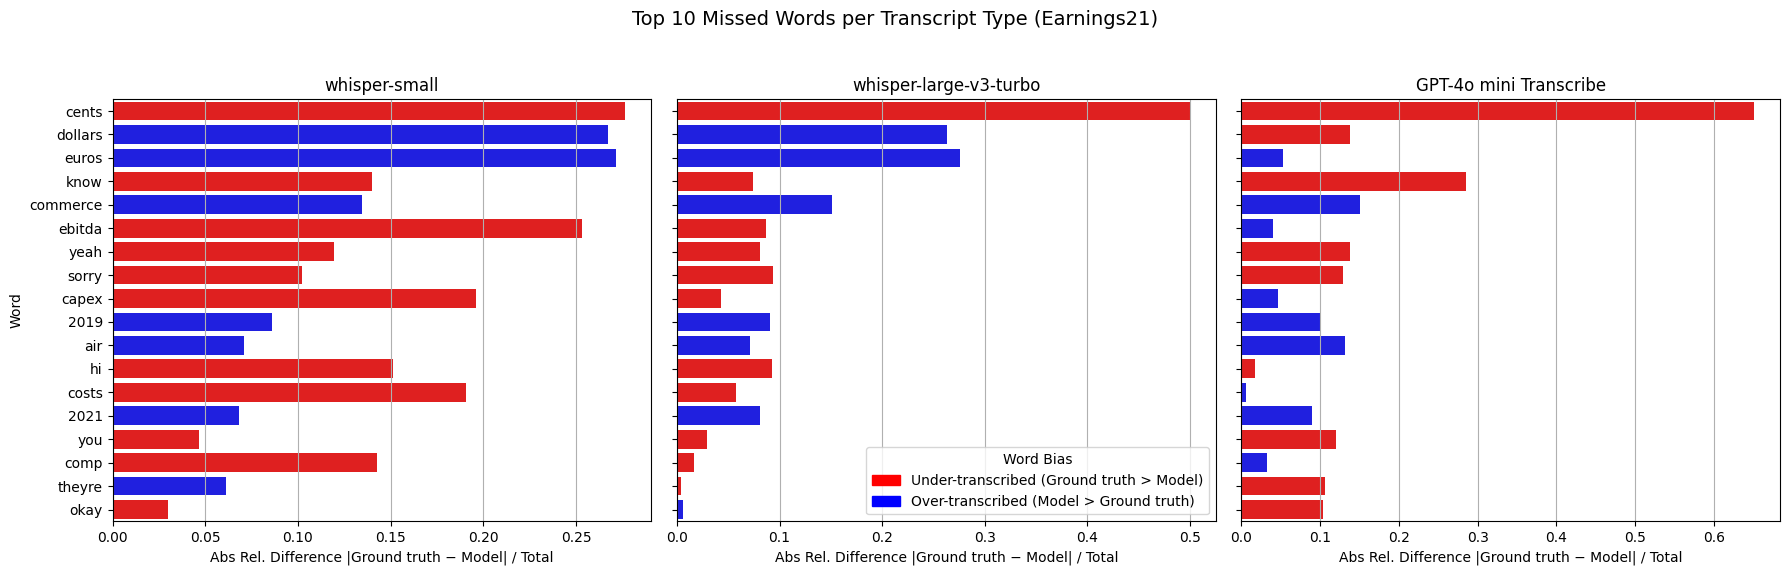

C:\Users\mark.welin\AppData\Local\Temp\ipykernel_13668\357443000.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='rel_diff', y='word',palette=df_plot.set_index('word').loc[df_plot['word'], 'color'].to_dict(),ax=ax,order=filter_words if filter_words else None)
C:\Users\mark.welin\AppData\Local\Temp\ipykernel_13668\357443000.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='rel_diff', y='word',palette=df_plot.set_index('word').loc[df_plot['word'], 'color'].to_dict(),ax=ax,order=filter_words if filter_words else None)
C:\Users\mark.welin\AppData\Local\Temp\ipykernel_13668\357443000.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is de

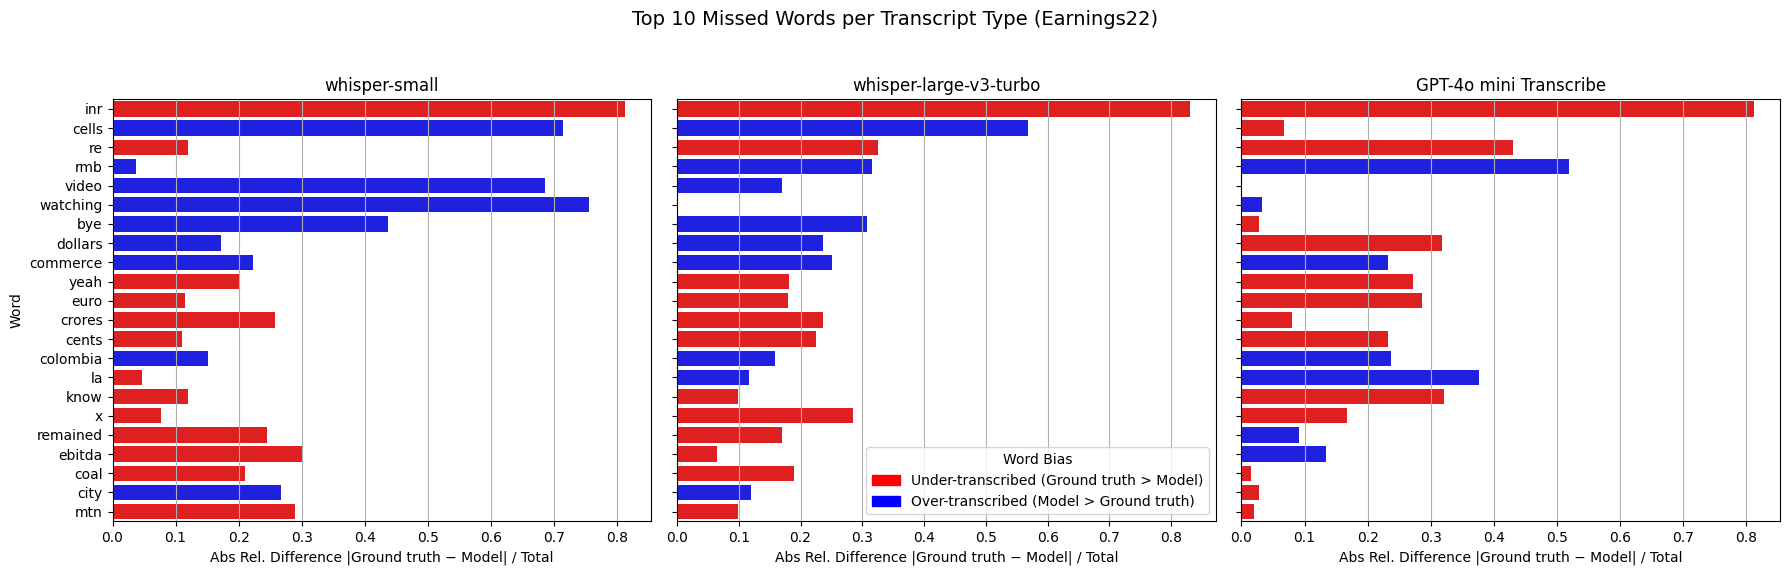

In [93]:
min_total = 100
#Removing folders that have too high of a WER for better analysis
def get_folders_with_all_wer_below(df_metrics, threshold=0.40):
    max_wer = df_metrics.groupby("folder")["wer"].max()
    return max_wer[max_wer < threshold].index.tolist()
def get_top_missed_words_by_variant(df_paths, label='', top_n=10, plot=True, filter_words=None):
    variants = df_paths['variant'].unique()
    fig, axes = plt.subplots(1, len(variants), figsize=(6 * len(variants), 6), sharey=True) if plot else (None, [None] * len(variants))
    if len(variants) == 1:
        axes = [axes]  

    all_top_words = []
    for i, (ax, variant) in enumerate(zip(axes, variants)):
        df_var = df_paths[df_paths['variant'] == variant]
        gt_words = []
        hyp_words = []

        for _, row in df_var.iterrows():
            gt_words += row['gt_text'].split()
            hyp_words += row['hyp_text'].split()

        gt_counter = Counter(gt_words)
        hyp_counter = Counter(hyp_words)
        all_words = set(gt_counter) | set(hyp_counter)

        data = []
        for word in all_words:
            gt_count = gt_counter[word]
            hyp_count = hyp_counter[word]
            total = gt_count + hyp_count
            color = 'red' if gt_count > hyp_count else 'blue'
            rel_diff = abs((gt_count - hyp_count)) / total
            data.append({
                'variant': variant,
                'word': word,
                'gt_count': gt_count,
                'hyp_count': hyp_count,
                'rel_diff': rel_diff,
                'total': total,
                'top' : False,
                'color': color
            })

        df_diff = pd.DataFrame(data)
        df_top = df_diff[df_diff['total'] > min_total].sort_values(by='rel_diff', ascending=False).head(top_n)
        df_diff['top'] = df_diff['word'].isin(df_top['word'])
        all_top_words.append(df_diff)
        if plot:
            if filter_words is not None:
                df_plot = df_diff[df_diff['word'].isin(filter_words)]
            else:
                df_plot = df_diff.sort_values(by='rel_diff', ascending=False).head(top_n)
            sns.barplot(data=df_plot, x='rel_diff', y='word',palette=df_plot.set_index('word').loc[df_plot['word'], 'color'].to_dict(),ax=ax,order=filter_words if filter_words else None)
            if i == 1:  # Only show legend on the middle plot
                legend_handles = [Patch(color='red', label='Under-transcribed (Ground truth > Model)'), Patch(color='blue', label='Over-transcribed (Model > Ground truth)')]
                ax.legend(handles=legend_handles, title='Word Bias', loc='lower right')
            ax.set_title(f"{variant}")
            ax.set_xlabel("Abs Rel. Difference |Ground truth − Model| / Total")
            ax.set_ylabel("Word")
            ax.grid(True, axis='x')

    if plot:
        plt.suptitle(f"Top {top_n} Missed Words per Transcript Type ({label})", fontsize=14)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
        return

    return pd.concat(all_top_words, ignore_index=True)




good_folders_21 = get_folders_with_all_wer_below(df_21, threshold=0.40)
good_folders_22 = get_folders_with_all_wer_below(df_22, threshold=0.40)

df_paths_21_filtered = df_paths_21[df_paths_21['folder'].isin(good_folders_21)]
df_paths_22_filtered = df_paths_22[df_paths_22['folder'].isin(good_folders_22)]

df_all_21 = get_top_missed_words_by_variant(df_paths_21_filtered, label='Earnings21', plot=False)
df_all_22 = get_top_missed_words_by_variant(df_paths_22_filtered, label='Earnings22', plot=False)


top_words_21 = df_all_21[(df_all_21['total'] > min_total) & (df_all_21['top'])]['word'].unique()
top_words_22 = df_all_22[(df_all_22['total'] > min_total) & (df_all_22['top'])]['word'].unique()

ordered_words_21 = (
    df_all_21[df_all_21['word'].isin(top_words_21)]
    .groupby('word', as_index=False)
    .agg({'rel_diff': 'mean'})
    .sort_values(by='rel_diff', ascending=False)
)
ordered_words_22 = (
    df_all_22[df_all_22['word'].isin(top_words_22)]
    .groupby('word', as_index=False)
    .agg({'rel_diff': 'mean'})
    .sort_values(by='rel_diff', ascending=False)
)
ordered_words_21 = ordered_words_21['word'].tolist()
ordered_words_22 = ordered_words_22['word'].tolist()

get_top_missed_words_by_variant(df_paths_21_filtered, label='Earnings21', plot=True, filter_words=ordered_words_21)
get_top_missed_words_by_variant(df_paths_22_filtered, label='Earnings22', plot=True, filter_words=ordered_words_22)


In [94]:
import re
from difflib import SequenceMatcher

# --- Financial keyword set ---
financial_keywords = {
    'revenue', 'sales', 'income', 'earnings', 'ebitda', 'ebit', 'profit', 'margin', 'cost', 'expenses',
    'capital', 'cash', 'dividend', 'tax', 'interest', 'guidance', 'estimate', 'forecast',
    'debt', 'loss', 'growth', 'operating', 'adjusted', 'net', 'return', 'liability', 'asset',
    'valuation', 'equity', 'shares', 'price', 'stock', 'unit', 'per share', 'ratio',
    'annual', 'fiscal', 'monthly'
}

def normalize_number(n):
    return str(float(n)) if '.' in n else str(int(n))

def extract_contextual_numbers(text, window=10):
    words = text.lower().split()
    numbers = []
    for idx, word in enumerate(words):
        if re.fullmatch(r'\d+(?:\.\d+)?', word):
            start = max(0, idx - window)
            end = min(len(words), idx + window + 1)
            context = words[start:end]
            if any(fin_word in context for fin_word in financial_keywords):
                numbers.append(normalize_number(word))
    return numbers

def count_aligned_numbers(gt_numbers, hyp_numbers):
    matcher = SequenceMatcher(None, gt_numbers, hyp_numbers)
    return sum(block.size for block in matcher.get_matching_blocks() if block.size > 0)

def evaluate_number_accuracy(df_paths):
    results = []
    variants = df_paths['variant'].unique()

    for variant in variants:
        df_var = df_paths[df_paths['variant'] == variant]

        gt_total = 0
        pred_total = 0
        correct_total = 0

        for _, row in df_var.iterrows():
            gt_numbers = extract_contextual_numbers(row['gt_text'])
            hyp_numbers = extract_contextual_numbers(row['hyp_text'])
            gt_total += len(gt_numbers)
            pred_total += len(hyp_numbers)
            correct_total += count_aligned_numbers(gt_numbers, hyp_numbers)

        precision = correct_total / pred_total if pred_total else 0
        recall = correct_total / gt_total if gt_total else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

        results.append({
            'variant': variant,
            'gt_total': gt_total,
            'pred_total': pred_total,
            'correct': correct_total,
            'precision': precision,
            'recall': recall,
            'f1': f1
        })

    # Overall totals
    totals = pd.DataFrame(results).sum(numeric_only=True)
    total_correct = totals['correct']
    total_pred = totals['pred_total']
    total_gt = totals['gt_total']
    total_precision = total_correct / total_pred if total_pred else 0
    total_recall = total_correct / total_gt if total_gt else 0
    total_f1 = 2 * total_precision * total_recall / (total_precision + total_recall) if (total_precision + total_recall) else 0

    results.append({
        'variant': 'TOTAL',
        'gt_total': total_gt,
        'pred_total': total_pred,
        'correct': total_correct,
        'precision': total_precision,
        'recall': total_recall,
        'f1': total_f1
    })
    

    df_result = pd.DataFrame(results)
    print(df_result.to_string(index=False, float_format='%.3f'))
    return df_result

# Run for each dataset
print("Number accuracy for combined_21:")
evaluate_number_accuracy(df_paths_21)
print("\nNumber accuracy for combined_22:")
evaluate_number_accuracy(df_paths_22)


Number accuracy for combined_21:
               variant  gt_total  pred_total  correct  precision  recall    f1
         whisper-small  3193.000    3183.000 2747.000      0.863   0.860 0.862
whisper-large-v3-turbo  3193.000    3239.000 2849.000      0.880   0.892 0.886
GPT-4o mini Transcribe  3193.000    3265.000 2895.000      0.887   0.907 0.897
                 TOTAL  9579.000    9687.000 8491.000      0.877   0.886 0.881

Number accuracy for combined_22:
               variant  gt_total  pred_total   correct  precision  recall    f1
         whisper-small  9253.000    8875.000  7456.000      0.840   0.806 0.823
whisper-large-v3-turbo  9253.000    9056.000  7805.000      0.862   0.844 0.853
GPT-4o mini Transcribe  9253.000    9254.000  8024.000      0.867   0.867 0.867
                 TOTAL 27759.000   27185.000 23285.000      0.857   0.839 0.848


,variant,gt_total,pred_total,correct,precision,recall,f1
0,whisper-small,9253.0,8875.0,7456.0,0.840113,0.805793,0.822595
1,whisper-large-v3-turbo,9253.0,9056.0,7805.0,0.861860,0.843510,0.852586
2,GPT-4o mini Transcribe,9253.0,9254.0,8024.0,0.867085,0.867178,0.867131
3,TOTAL,27759.0,27185.0,23285.0,0.856539,0.838827,0.847590


In [95]:
def compute_numerical_error_per_row(df_paths):
    errors = []

    for _, row in df_paths.iterrows():
        gt_numbers = extract_contextual_numbers(row['gt_text'])
        hyp_numbers = extract_contextual_numbers(row['hyp_text'])

        gt_total = len(gt_numbers)
        pred_total = len(hyp_numbers)
        correct = count_aligned_numbers(gt_numbers, hyp_numbers)

        precision = correct / pred_total if pred_total else 0
        recall = correct / gt_total if gt_total else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

        errors.append({
            "folder": row["folder"],
            "variant": row["variant"],
            "numerical_error": 1 - f1
        })

    return pd.DataFrame(errors)

# Compute and merge into df_21 and df_22
df_21 = df_21.merge(compute_numerical_error_per_row(df_paths_21), on=["folder", "variant"], how="left")
df_22 = df_22.merge(compute_numerical_error_per_row(df_paths_22), on=["folder", "variant"], how="left")


In [96]:

# Make sure high-WER flag is set
df_22['high_wer'] = df_22['wer'] > 0.4

# Filter for high-WER rows
high_wer_files = df_22[df_22['high_wer'] == True][['folder', 'variant', 'wer', 'numerical_error']].drop_duplicates()

# Merge with transcripts
df_merged = high_wer_files.merge(
    df_paths_22[['folder', 'variant', 'gt_text', 'hyp_text']],
    on=['folder', 'variant'],
    how='inner'
)

# --- Alignment Errors ---
def classify_alignment_errors(gt_words, hyp_words):
    matcher = SequenceMatcher(None, gt_words, hyp_words)
    errors = {'deletion': 0, 'insertion': 0, 'substitution': 0}
    for tag, i1, i2, j1, j2 in matcher.get_opcodes():
        if tag == 'replace':
            errors['substitution'] += max(i2 - i1, j2 - j1)
        elif tag == 'delete':
            errors['deletion'] += i2 - i1
        elif tag == 'insert':
            errors['insertion'] += j2 - j1
    return errors

# --- Number Extraction and Normalization ---
financial_keywords = {
    'revenue', 'sales', 'income', 'earnings', 'ebitda', 'ebit', 'profit', 'margin', 'cost', 'expenses',
    'capital', 'cash', 'dividend', 'tax', 'interest', 'guidance', 'estimate', 'forecast',
    'debt', 'loss', 'growth', 'operating', 'adjusted', 'net', 'return', 'liability', 'asset',
    'valuation', 'equity', 'shares', 'price', 'stock', 'unit', 'per share', 'ratio',
    'annual', 'fiscal', 'monthly'
}

def extract_contextual_numbers(text, window=10):
    words = text.lower().split()
    numbers = []
    for idx, word in enumerate(words):
        if re.fullmatch(r'\d+(?:\.\d+)?', word):
            start = max(0, idx - window)
            end = min(len(words), idx + window + 1)
            context = words[start:end]
            if any(fin_word in context for fin_word in financial_keywords):
                numbers.append(word)
    return numbers

def normalize_number(n):
    return str(float(n)).rstrip('0').rstrip('.') if '.' in n else str(int(n))

# --- Print Report ---
print("\nError stats for files with WER > 40%:\n")
for _, row in df_merged.iterrows():
    gt_words = row['gt_text'].split()
    hyp_words = row['hyp_text'].split()
    total_words = len(gt_words)

    errs = classify_alignment_errors(gt_words, hyp_words)
    wer_calc = (errs['deletion'] + errs['insertion'] + errs['substitution']) / total_words if total_words > 0 else 0

    # Extract normalized financial numbers
    gt_numbers = [normalize_number(n) for n in extract_contextual_numbers(row['gt_text'])]
    hyp_numbers = [normalize_number(n) for n in extract_contextual_numbers(row['hyp_text'])]

    print(f"Folder: {row['folder']}, Variant: {row['variant']}")
    print(f"  WER (recomputed): {wer_calc:.2%}")
    print(f"  WER (from df_22): {row['wer']:.2%}")
    print(f"  Insertions: {errs['insertion']}, Deletions: {errs['deletion']}, Substitutions: {errs['substitution']}")
    print(f"  Numeric error: {row['numerical_error']:.2%}")




Error stats for files with WER > 40%:



In [97]:
# Merge language family info
df_paths_22 = df_paths_22.merge(df_22[["folder", "Language Family"]], on="folder", how="left")

# Evaluate per language family
all_results = []

for family in df_22["Language Family"].dropna().unique():
    df_subset = df_22[df_22["Language Family"] == family].copy()
    print(f"\n Evaluating for Language Family: {family}")
    
    result = evaluate_number_accuracy(df_subset)
    result["Language Family"] = family
    all_results.append(result)

# Combine
df_family_results = pd.concat(all_results, ignore_index=True)

# Filter totals only
df_totals = df_family_results[df_family_results["variant"] == "TOTAL"]

# Add WER means from df_22
wer_means = df_22.groupby("Language Family")["wer"].mean().reset_index()
df_plot = df_totals.merge(wer_means, on="Language Family")

# Calculate numerical error = 1 - F1
df_plot["Numerical Error"] = 1 - df_plot["f1"]


 Evaluating for Language Family: African
               variant  gt_total  pred_total  correct  precision  recall    f1
         whisper-small   312.000     298.000  257.000      0.862   0.824 0.843
whisper-large-v3-turbo   312.000     311.000  274.000      0.881   0.878 0.880
GPT-4o mini Transcribe   312.000     316.000  278.000      0.880   0.891 0.885
                 TOTAL   936.000     925.000  809.000      0.875   0.864 0.869

 Evaluating for Language Family: Spanish/Portuguese
               variant  gt_total  pred_total  correct  precision  recall    f1
         whisper-small  2308.000    2157.000 1801.000      0.835   0.780 0.807
whisper-large-v3-turbo  2308.000    2238.000 1914.000      0.855   0.829 0.842
GPT-4o mini Transcribe  2308.000    2304.000 1977.000      0.858   0.857 0.857
                 TOTAL  6924.000    6699.000 5692.000      0.850   0.822 0.836

 Evaluating for Language Family: Asian
               variant  gt_total  pred_total  correct  precision  recall   

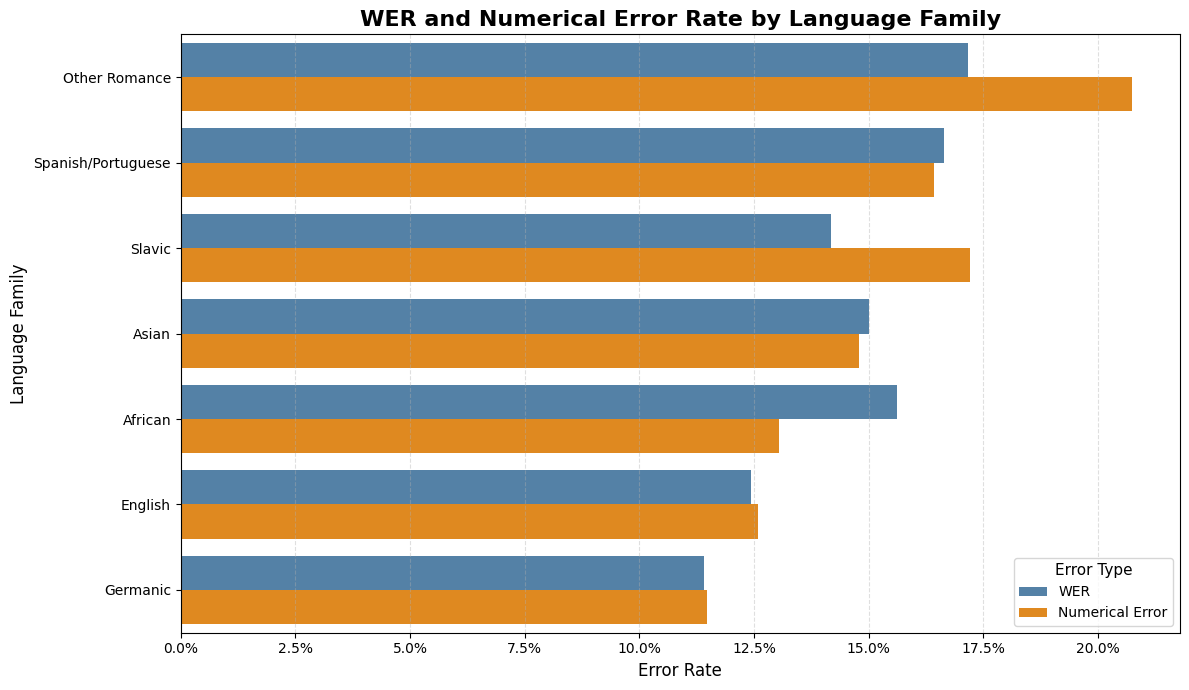

In [98]:
from matplotlib.ticker import PercentFormatter

# Fix legend label capitalization
df_long = df_plot.melt(
    id_vars=["Language Family", "Total Hours"] if "Total Hours" in df_plot else ["Language Family"],
    value_vars=["wer", "Numerical Error"],
    var_name="Error Type",
    value_name="Error Rate"
)

# Capitalize "wer" label
df_long["Error Type"] = df_long["Error Type"].replace({"wer": "WER"})

# Sort language families by average error
sort_order = (
    df_long.groupby("Language Family")["Error Rate"]
    .mean()
    .sort_values(ascending=False)
    .index
)

# Create the plot
plt.figure(figsize=(12, 7))
ax = sns.barplot(
    data=df_long,
    x="Error Rate",
    y="Language Family",
    hue="Error Type",
    order=sort_order,
    palette={"WER": "steelblue", "Numerical Error": "darkorange"}
)


# Set axis labels and title
plt.title("WER and Numerical Error Rate by Language Family", fontsize=16, weight='bold')
plt.xlabel("Error Rate", fontsize=12)
plt.ylabel("Language Family", fontsize=12)

# Format x-axis as percent
ax.xaxis.set_major_formatter(PercentFormatter(1.0))
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Tweak legend
plt.legend(title="Error Type", title_fontsize=11, fontsize=10)
plt.tight_layout()
plt.show()


3 assumptions:

1. The responses for each factor level have a normal population distribution (Shapiro-Wilk test)
2. These distributions have the same variance. (Levene's test )
3. The data are independent. (Some calls are from the same company, are they independant?)


Use Friedman Test in SPSS Statistics

or

Kruskal-Wallis H test H (Here there is also independence being assumed.)



 Kruskal-Wallis tests for model: whisper-small
   WER: Statistic = 18.906, p-value = 0.0020


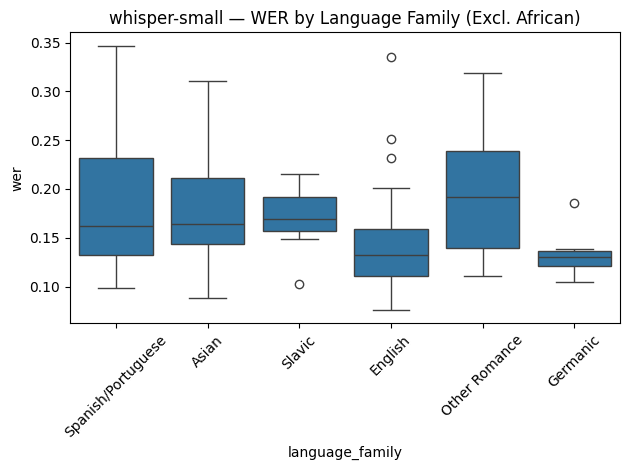

   Numerical Error: Statistic = 13.743, p-value = 0.0173


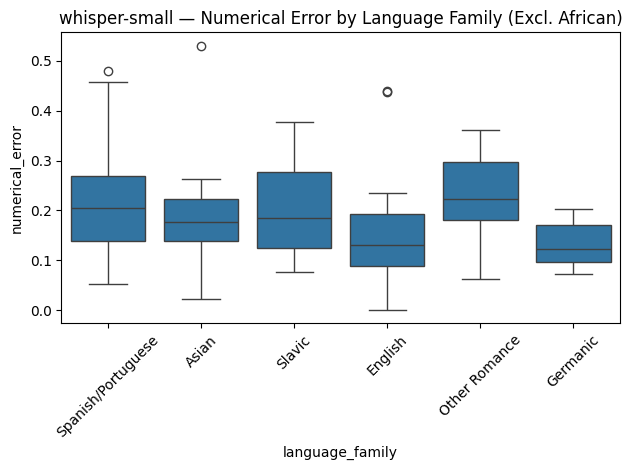


 Kruskal-Wallis tests for model: whisper-large-v3-turbo
   WER: Statistic = 23.091, p-value = 0.0003


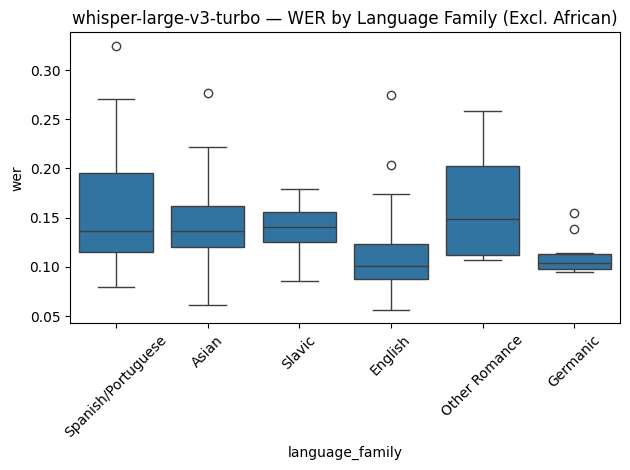

   Numerical Error: Statistic = 11.665, p-value = 0.0397


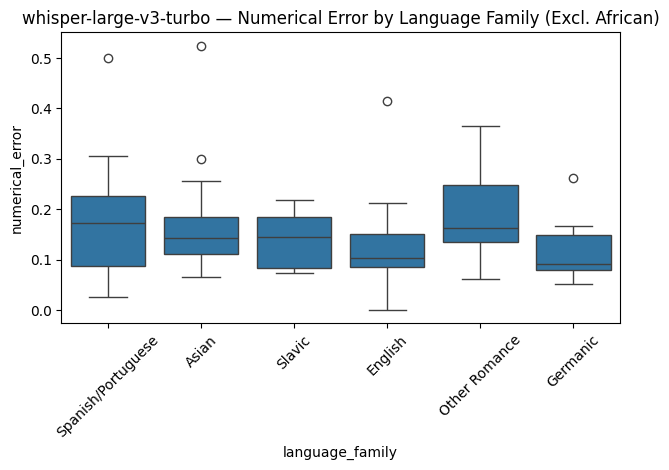


 Kruskal-Wallis tests for model: GPT-4o mini Transcribe
   WER: Statistic = 12.350, p-value = 0.0303


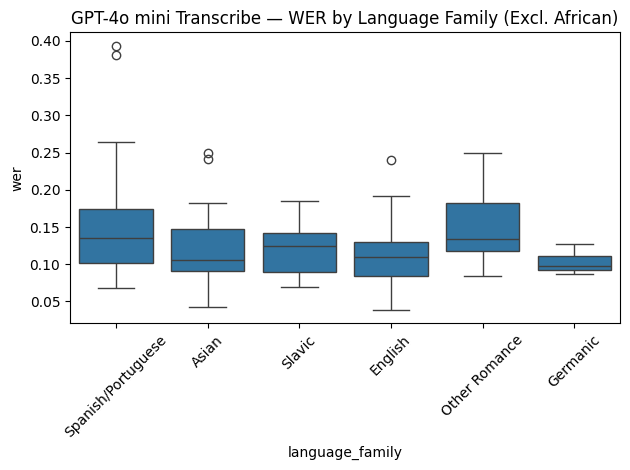

   Numerical Error: Statistic = 10.834, p-value = 0.0548


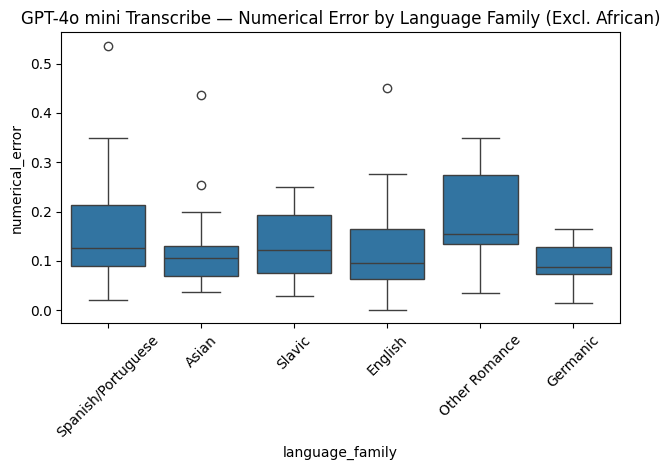

In [99]:
from scipy.stats import kruskal
import seaborn as sns
import matplotlib.pyplot as plt

# Rename for consistency
df_22 = df_22.rename(columns={
    "Language Family": "language_family",
    "Ticker Symbol": "ticker_symbol"
})

# Drop rows with missing values in critical columns
df_clean = df_22.dropna(subset=["language_family", "ticker_symbol", "variant", "wer", "numerical_error"])

#Subset without African language family
df_subset = df_clean[df_clean["language_family"] != "African"]

# Sample one folder per ticker to ensure independence
sampled_folders = (
    df_subset.groupby("ticker_symbol")["folder"]
    .apply(lambda x: x.sample(n=1, random_state=42))
    .reset_index(drop=True)
)

# Keep all 3 model variants for the selected folders
df_one_call_per_ticker = df_subset[df_subset["folder"].isin(sampled_folders)]

# Run Kruskal-Wallis tests
for variant in df_one_call_per_ticker["variant"].unique():
    print(f"\n Kruskal-Wallis tests for model: {variant}")

    df_variant = df_one_call_per_ticker[df_one_call_per_ticker["variant"] == variant]

    # ---- WER ----
    grouped_wer = [group["wer"].values for _, group in df_variant.groupby("language_family")]
    if len(grouped_wer) >= 2:
        stat, p = kruskal(*grouped_wer)
        print(f"   WER: Statistic = {stat:.3f}, p-value = {p:.4f}")
        sns.boxplot(data=df_variant, x="language_family", y="wer")
        plt.title(f"{variant} — WER by Language Family (Excl. African)")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("  ⚠️ Not enough language families with WER to compare.")

    # ---- Numerical Error ----
    grouped_num = [group["numerical_error"].values for _, group in df_variant.groupby("language_family")]
    if len(grouped_num) >= 2:
        stat, p = kruskal(*grouped_num)
        print(f"   Numerical Error: Statistic = {stat:.3f}, p-value = {p:.4f}")
        sns.boxplot(data=df_variant, x="language_family", y="numerical_error")
        plt.title(f"{variant} — Numerical Error by Language Family (Excl. African)")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print("   Not enough language families with numerical error to compare.")


In [100]:
# Count how many times each Ticker Symbol appears
ticker_counts = df_22["ticker_symbol"].value_counts()

# Show how many tickers appear more than once
num_repeated_tickers = (ticker_counts > 1).sum()
print(f"Number of tickers with more than one file: {num_repeated_tickers}")

# Optionally: preview top 10 most repeated tickers
print("\nTop repeated tickers:")
print(ticker_counts.head(10))
print("Unique tickers:", len(ticker_counts))

Number of tickers with more than one file: 111

Top repeated tickers:
ticker_symbol
MTNGH    12
OTGLF     9
SOSSF     6
KGHPF     6
HEPS      6
EDPFY     3
LTM       3
TLK       3
ITCB      3
KB        3
Name: count, dtype: int64
Unique tickers: 111


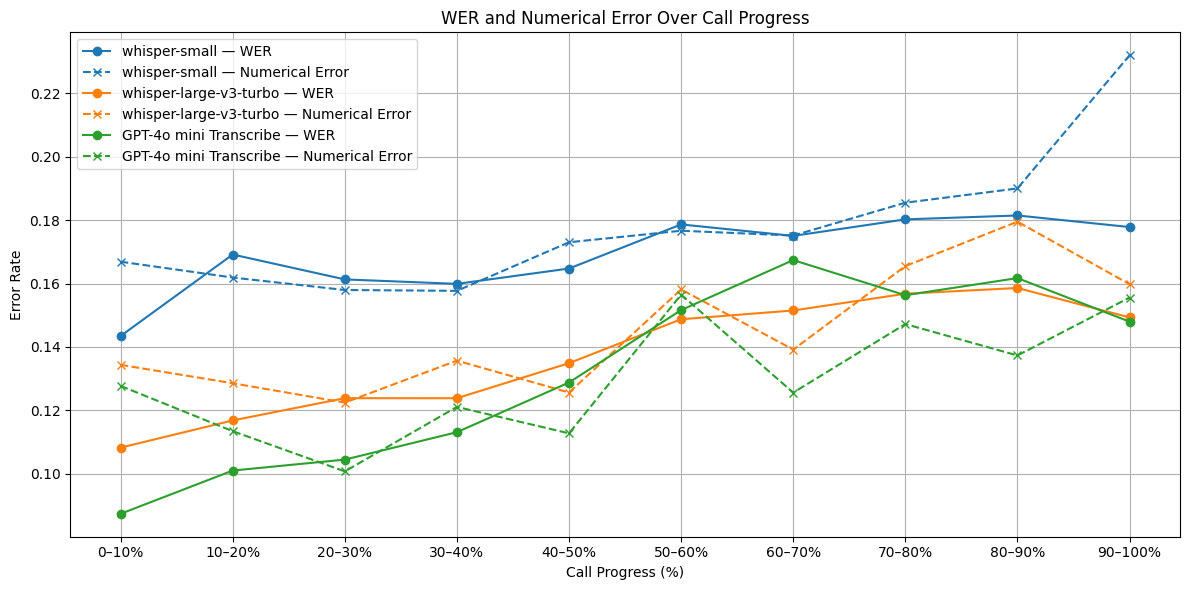

In [51]:
df_all = pd.concat([df_paths_21, df_paths_22], ignore_index=True)
variants = df_all['variant'].unique()
n_bins = 10

bin_wer_data = {v: [[] for _ in range(n_bins)] for v in variants}
bin_num_match = {v: [0] * n_bins for v in variants}
bin_num_gt = {v: [0] * n_bins for v in variants}
bin_num_hyp = {v: [0] * n_bins for v in variants}

total_wer_by_model = {}
total_numerr_by_model = {}



def aligned_split(gt, hyp, n_bins):
    # Use SequenceMatcher to align GT and Hyp
    matcher = SequenceMatcher(None, gt, hyp)
    blocks = matcher.get_matching_blocks()

    # Build GT → Hyp index mapping based on matching blocks
    gt_to_hyp = {}
    for block in blocks:
        for i in range(block.size):
            gt_to_hyp[block.a + i] = block.b + i  # map GT index to corresponding Hyp index

    # Split GT into 10 bins
    gt_split_indices = np.linspace(0, len(gt), n_bins + 1, dtype=int)
    gt_chunks = [gt[gt_split_indices[i]:gt_split_indices[i+1]] for i in range(n_bins)]

    hyp_chunks = []
    for i in range(n_bins):
        gt_start, gt_end = gt_split_indices[i], gt_split_indices[i+1]
        # Find corresponding Hyp indices from GT-Hyp mapping
        hyp_indices = [gt_to_hyp[j] for j in range(gt_start, gt_end) if j in gt_to_hyp]
        if hyp_indices:
            hyp_start, hyp_end = min(hyp_indices), max(hyp_indices) + 1
            hyp_chunks.append(hyp[hyp_start:hyp_end])
        else:
            hyp_chunks.append([])  # No match — empty chunk

    return gt_chunks, hyp_chunks
def compute_wer(gt_tokens, hyp_tokens):
    return compute_measures(" ".join(gt_tokens), " ".join(hyp_tokens))["wer"]

def normalize_number(n):
    return str(float(n)) if '.' in n else str(int(n))

def extract_contextual_numbers(tokens, window=10):
    numbers = []
    for i, w in enumerate(tokens):
        if re.fullmatch(r'\d+(?:\.\d+)?', w):
            context = tokens[max(0, i - window):min(len(tokens), i + window + 1)]
            if any(fin in context for fin in financial_keywords):
                numbers.append(normalize_number(w))
    return numbers

def count_aligned_numbers(gt, hyp):
    return sum(block.size for block in SequenceMatcher(None, gt, hyp).get_matching_blocks() if block.size > 0)

for variant in variants:
    wers = []
    numerrs = []
    df_var = df_all[df_all["variant"] == variant]

    for _, row in df_var.iterrows():
        gt = row["gt_text"].split()
        hyp = row["hyp_text"].split()
        gt_chunks, hyp_chunks = aligned_split(gt, hyp, n_bins)
        
        for i in range(n_bins):
            bin_wer_data[variant][i].append(compute_wer(gt_chunks[i], hyp_chunks[i]))
            gt_n = extract_contextual_numbers(gt_chunks[i])
            hyp_n = extract_contextual_numbers(hyp_chunks[i])
            c = count_aligned_numbers(gt_n, hyp_n)
            p = c / len(hyp_n) if hyp_n else 0
            r = c / len(gt_n) if gt_n else 0
            f1 = 2*p*r / (p+r) if p+r else 0
            bin_num_match[variant][i] += c
            bin_num_gt[variant][i] += len(gt_n)
            bin_num_hyp[variant][i] += len(hyp_n)




positions = np.arange(n_bins)
plt.figure(figsize=(12, 6))


color_map = {
    variant: color for variant, color in zip(
        variants, plt.cm.tab10.colors[:len(variants)]
    )
}

for v in variants:
    wer_means = [np.mean(b) if b else 0 for b in bin_wer_data[v]]
    num_means = []
    for i in range(n_bins):
        c = bin_num_match[v][i]
        g = bin_num_gt[v][i]
        h = bin_num_hyp[v][i]
        p = c / h if h else 0
        r = c / g if g else 0
        f1 = 2 * p * r / (p + r) if (p + r) else 0
        num_means.append(1 - f1)

    plt.plot(
        positions + 1, wer_means, marker='o', linestyle='-', color=color_map[v],
        label=f"{v} — WER"
    )
    plt.plot(
        positions + 1, num_means, marker='x', linestyle='--', color=color_map[v],
        label=f"{v} — Numerical Error"
    )

plt.xticks(positions + 1, [f"{i*10}–{(i+1)*10}%" for i in range(n_bins)])
plt.xlabel("Call Progress (%)")
plt.ylabel("Error Rate")
plt.title("WER and Numerical Error Over Call Progress")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [52]:
number_counts_per_bin = [0] * n_bins
total_calls_with_bin = [0] * n_bins

for _, row in df_all.iterrows():
    gt = row["gt_text"].split()
    hyp = row["hyp_text"].split()

    if len(gt) < n_bins or not hyp:
        continue

    gt_chunks, _ = aligned_split(gt, hyp, n_bins)

    for i in range(n_bins):
        num_count = len(extract_contextual_numbers(gt_chunks[i]))
        number_counts_per_bin[i] += num_count
        total_calls_with_bin[i] += 1

print("Average contextual number count per bin:")
for i in range(n_bins):
    avg = number_counts_per_bin[i] / total_calls_with_bin[i] if total_calls_with_bin[i] > 0 else 0
    print(f"Bin {i} ({i*10}–{(i+1)*10}%): {avg:.2f} numbers")


Average contextual number count per bin:
Bin 0 (0–10%): 9.38 numbers
Bin 1 (10–20%): 13.36 numbers
Bin 2 (20–30%): 14.47 numbers
Bin 3 (30–40%): 12.28 numbers
Bin 4 (40–50%): 7.96 numbers
Bin 5 (50–60%): 5.41 numbers
Bin 6 (60–70%): 3.87 numbers
Bin 7 (70–80%): 3.74 numbers
Bin 8 (80–90%): 3.39 numbers
Bin 9 (90–100%): 2.86 numbers


In [23]:
def evaluate_simple_variant(base_folder, suffix="simple.txt"):
    rows = []
    for subdir in os.listdir(base_folder):
        full_path = os.path.join(base_folder, subdir)
        if os.path.isdir(full_path):
            files = os.listdir(full_path)
            
            # Identify GT file
            gt_file = [f for f in files if f.endswith('.txt') 
                       and not any(f.endswith(s) for s in ['_Whisper.txt', '_Turbo_Whisper.txt', '_openai_transcript.txt', '_timing.txt', suffix])]
            simple_file = f"{subdir}{suffix}"
            
            if gt_file and simple_file in files:
                gt_path = os.path.join(full_path, gt_file[0])
                hyp_path = os.path.join(full_path, simple_file)

                gt = read_txt_file(gt_path)
                hyp = read_txt_file(hyp_path)

                gt_words = apply_substitutions(clean_and_tokenize(gt))
                hyp_words = apply_substitutions(clean_and_tokenize(hyp))

                gt_cleaned = [w for w in gt_words if w not in FILLERS]
                hyp_cleaned = [w for w in hyp_words if w not in FILLERS]

                metrics = compute_metrics(' '.join(gt_cleaned), ' '.join(hyp_cleaned))

                # Numerical error
                gt_numbers = extract_contextual_numbers(' '.join(gt_cleaned))
                hyp_numbers = extract_contextual_numbers(' '.join(hyp_cleaned))
                correct = count_aligned_numbers(gt_numbers, hyp_numbers)
                precision = correct / len(hyp_numbers) if hyp_numbers else 0
                recall = correct / len(gt_numbers) if gt_numbers else 0
                f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0

                rows.append({
                    "folder": subdir,
                    "wer": metrics["wer"],
                    "mer": metrics["mer"],
                    "wil": metrics["wil"],
                    "numerical_error": 1 - f1,
                    "gt_number_count": len(gt_numbers),
                    "hyp_number_count": len(hyp_numbers),
                    "matched_numbers": correct
                })

    df_simple = pd.DataFrame(rows)
    print("Average Metrics for _simple.txt variant:")
    print(df_simple[["wer", "mer", "wil", "numerical_error"]].mean())
    return df_simple

# Example usage
df_simple_21 = evaluate_simple_variant("Data/combined_21")
df_simple_22 = evaluate_simple_variant("Data/combined_22")


Average Metrics for _simple.txt variant:
wer                0.090779
mer                0.088801
wil                0.123322
numerical_error    0.113536
dtype: float64
Average Metrics for _simple.txt variant:
wer                0.134322
mer                0.128033
wil                0.175130
numerical_error    0.122221
dtype: float64


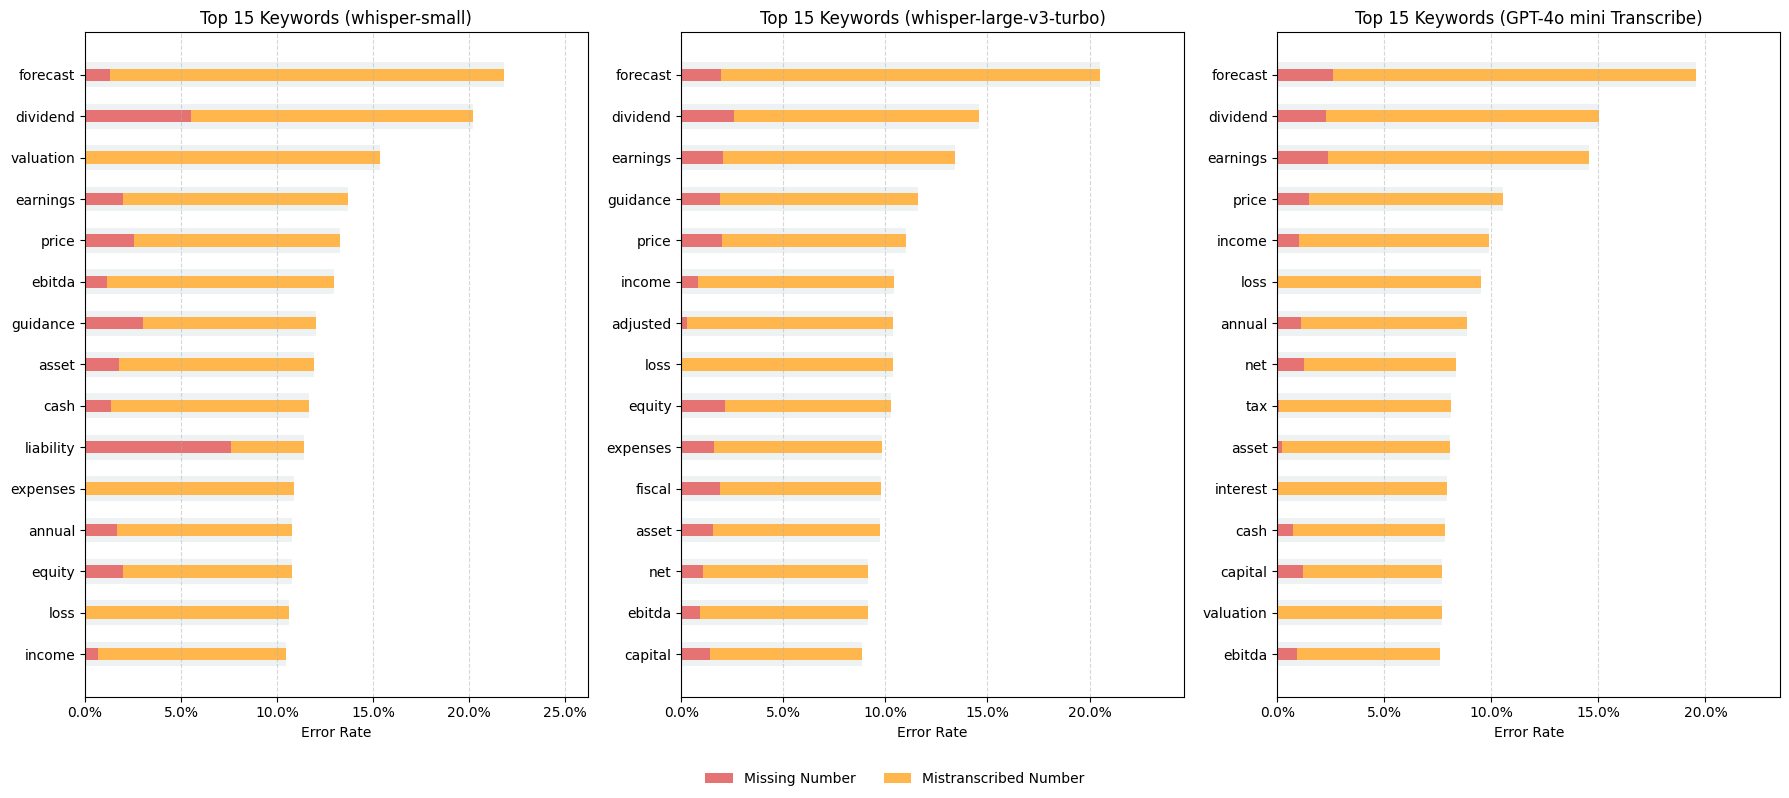

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.ticker as mtick

# Load CSV
df_result = pd.read_csv("financial_keyword_error_summary.csv")

# Compute error metrics
df_result["error_total"] = df_result["missing"] + df_result["substituted"]
df_result["total_checked"] = df_result["correct"] + df_result["error_total"]
df_result["error_rate"] = df_result["error_total"] / df_result["total_checked"]
df_result["missing_rate"] = df_result["missing"] / df_result["total_checked"]
df_result["substituted_rate"] = df_result["substituted"] / df_result["total_checked"]

# Colors (Option A: Clean & Warm)
missing_color = "#E57373"
substituted_color = "#FFB74D"
total_bar_color = "#B0BEC5"

# Prepare subplots
variants = df_result["variant"].unique()
n_variants = len(variants)

fig, axes = plt.subplots(1, n_variants, figsize=(6 * n_variants, 8), sharex=False)

for ax, variant in zip(axes, variants):
    df_var = df_result[df_result["variant"] == variant].copy()
    df_var = df_var[df_var["total_checked"] >= 5]
    df_top = df_var.sort_values("error_rate", ascending=False).head(15)
    df_top = df_top[::-1]

    y_pos = np.arange(len(df_top))
    max_error = df_top["error_rate"].max()
    x_limit = min(1.0, max_error * 1.2)

    # Transparent base bar
    ax.barh(y_pos, df_top["error_rate"], height=0.6, color=total_bar_color, alpha=0.2)
    # Stacked bars
    ax.barh(y_pos, df_top["missing_rate"], height=0.3, color=missing_color, label="Missing Number")
    ax.barh(y_pos, df_top["substituted_rate"], height=0.3,
            left=df_top["missing_rate"], color=substituted_color, label="Mistranscribed Number")

    ax.set_yticks(y_pos)
    ax.set_yticklabels(df_top["keyword"])
    ax.set_xlim(0, x_limit)
    ax.set_xlabel("Error Rate")
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.set_title(f"Top 15 Keywords ({variant})")
    ax.grid(axis="x", linestyle="--", alpha=0.5)

# Add legend once (bottom center)
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, frameon=False)

plt.tight_layout(rect=[0, 0.05, 1, 1])  # leave space for legend
plt.show()


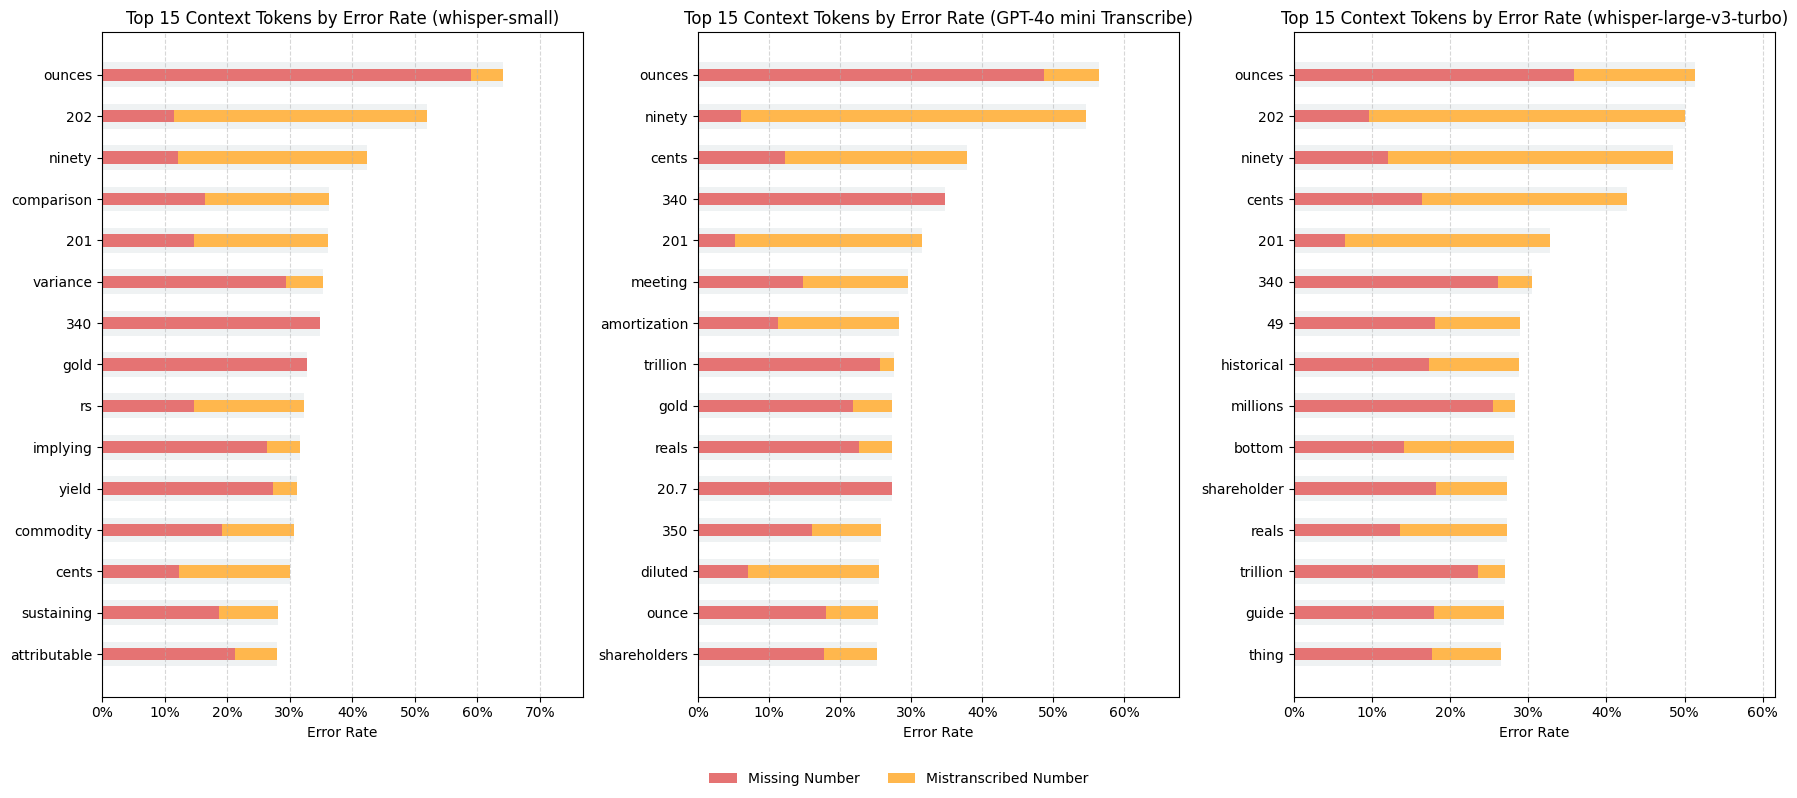

In [87]:
# Load token-level error summary
df_token = pd.read_csv("token_error_summary.csv")

# Compute error breakdowns
df_token["missing_rate"] = df_token["missing"] / df_token["total"]
df_token["substituted_rate"] = df_token["substituted"] / df_token["total"]

# Define colors
missing_color = "#E57373"         # Soft red
substituted_color = "#FFB74D"     # Warm orange
total_bar_color = "#B0BEC5"       # Neutral gray

# Get model variants
variants = df_token["variant"].unique()
n_variants = len(variants)

# Create subplots
fig, axes = plt.subplots(1, n_variants, figsize=(6 * n_variants, 8), sharex=False)

# Ensure axes is iterable
if n_variants == 1:
    axes = [axes]

for ax, variant in zip(axes, variants):
    df_var = df_token[df_token["variant"] == variant].copy()
    df_top = df_var.sort_values("error_rate", ascending=False).head(15)
    df_top = df_top[::-1]  # Highest error at top

    y_pos = np.arange(len(df_top))
    max_error = df_top["missing_rate"].add(df_top["substituted_rate"]).max()
    x_limit = min(1.0, max_error * 1.2)

    # Transparent total error bar
    ax.barh(y_pos, df_top["missing_rate"] + df_top["substituted_rate"],
            height=0.6, color=total_bar_color, alpha=0.2)

    # Stacked error bars
    ax.barh(y_pos, df_top["missing_rate"], height=0.3, color=missing_color, label="Missing Number")
    ax.barh(y_pos, df_top["substituted_rate"], height=0.3,
            left=df_top["missing_rate"], color=substituted_color, label="Mistranscribed Number")

    # Axis styling
    ax.set_yticks(y_pos)
    ax.set_yticklabels(df_top["token"])
    ax.set_xlim(0, x_limit)
    ax.set_xlabel("Error Rate")
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    ax.set_title(f"Top 15 Context Tokens by Error Rate ({variant})")
    ax.grid(axis="x", linestyle="--", alpha=0.5)

# Add a shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, frameon=False)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


**LONG RUNNING TIME BLOCKS**

Making lists of examples:

In [ ]:
# Seed for reproducibility
random.seed(42)

# Combine and identify direction of bias
bias_info = {}
for df_all in [df_all_21, df_all_22]:
    for _, row in df_all.iterrows():
        if row["top"]:
            bias_info[row["word"]] = "under" if row["gt_count"] > row["hyp_count"] else "over"

# Set of all top words
top_words = set(bias_info.keys())

# Parameters
chunk_size = 20
window_range = 300
sample_limit = 30

# Store results
context_examples = []

datasets = [("Earnings21", df_paths_21), ("Earnings22", df_paths_22)]

for label, df_paths in datasets:
    for _, row in df_paths.iterrows():
        gt_text = row['gt_text'].lower()
        hyp_text = row['hyp_text'].lower()

        gt_words = re.findall(r'\b\w+\b', gt_text)
        hyp_words = re.findall(r'\b\w+\b', hyp_text)

        gt_text_str = ' '.join(gt_words)
        hyp_text_str = ' '.join(hyp_words)

        # Prepare hypothesis chunks
        hyp_snippets = [' '.join(hyp_words[i:i + chunk_size]) for i in range(len(hyp_words) - chunk_size + 1)]
        gt_snippets = [' '.join(gt_words[i:i + chunk_size]) for i in range(len(gt_words) - chunk_size + 1)]

        # Search through either GT or Hyp based on over/under transcription
        for word in top_words:
            direction = bias_info[word]
            text_tokens = gt_words if direction == 'under' else hyp_words
            other_text = hyp_text_str if direction == 'under' else gt_text_str
            snippets = gt_snippets if direction == 'over' else hyp_snippets

            word_indices = [i for i, token in enumerate(text_tokens) if token == word]
            if not word_indices:
                continue

            sampled_indices = word_indices  # Use all occurrences

            for i in sampled_indices:
                start = max(i - 10, 0)
                end = min(i + 11, len(text_tokens))
                target_snippet = ' '.join(text_tokens[start:end])
                approx_chunk = int(i * len(snippets) / len(text_tokens))
                chunk_start = max(approx_chunk - window_range, 0)
                chunk_end = min(approx_chunk + window_range + 1, len(snippets))
                local_snippets = snippets[chunk_start:chunk_end]

                best_match, score, _ = process.extractOne(
                    target_snippet, local_snippets, scorer=fuzz.partial_ratio
                )

                if not best_match or score < 70:
                    continue

                # Check if word is only in one of the two sentences
                target_words = set(re.findall(r'\b\w+\b', target_snippet))
                match_words = set(re.findall(r'\b\w+\b', best_match))
                if (word in target_words) != (word in match_words):
                    context_examples.append({
                        'word': word,
                        'bias_direction': direction,
                        'gt_snippet': target_snippet if direction == 'under' else best_match,
                        'hyp_snippet': best_match if direction == 'under' else target_snippet,
                        'match_score': score,
                        'dataset': label,
                        'folder': row['folder']
                    })

# Save results
df_context = pd.DataFrame(context_examples)
df_context.to_csv('biased_word_context_examples.csv', index=False)
print(f"Saved {len(df_context)} examples to 'biased_word_context_examples.csv'")


Saved 20235 examples to 'biased_word_context_examples.csv'


Number exploration

In [77]:
#MAKING CSV ON FINANCIAL KEYWORDS

df_all = pd.concat([df_paths_21, df_paths_22], ignore_index=True)

# Parameters
window = 10
score_threshold = 70
number_pattern = r'\d+(?:\.\d+)?'
chunk_size = 20
slide_step = 4
window_range = 300

# Financial keywords
financial_keywords = {
    'revenue', 'sales', 'income', 'earnings', 'ebitda', 'ebit', 'profit', 'margin', 'cost', 'expenses',
    'capital', 'cash', 'dividend', 'tax', 'interest', 'guidance', 'estimate', 'forecast',
    'debt', 'loss', 'growth', 'operating', 'adjusted', 'net', 'return', 'liability', 'asset',
    'valuation', 'equity', 'shares', 'price', 'stock', 'unit', 'per share', 'ratio',
    'annual', 'fiscal', 'monthly'
}

# Normalize number
def normalize_number(n):
    return str(float(n)) if '.' in n else str(int(n))

# Extract numbers within financial context
def extract_financial_number_contexts(words, window=10):
    results = []
    for idx, word in enumerate(words):
        if re.fullmatch(number_pattern, word):
            start = max(0, idx - window)
            end = min(len(words), idx + window + 1)
            context = words[start:end]
            if any(fin_word in context for fin_word in financial_keywords):
                results.append((idx, normalize_number(word), context))
    return results

# Detect error type between two numbers
def detect_error(gt_number, hyp_numbers, gt_numbers):
    if gt_number in hyp_numbers:
        return "correct"
    # Remove the current gt_number and check if the rest are present in hyp_numbers
    other_gt_numbers = [n for n in gt_numbers if n != gt_number]
    other_matches = [n for n in other_gt_numbers if n in hyp_numbers]

    if len(gt_numbers) > len(hyp_numbers) and len(other_gt_numbers) == len(other_matches):
        return "missing"  # all others match, this one is missing
    else:
        return "substituted"

# Collect error counts
error_counts = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))  # model -> keyword -> type -> count

# Evaluate
for variant in df_all['variant'].unique():
    df_variant = df_all[df_all['variant'] == variant]
    for _, row in df_variant.iterrows():
        gt_tokens = row['gt_text'].split()
        hyp_tokens = row['hyp_text'].split()
        if len(gt_tokens) < 20 or len(hyp_tokens) < 20:
            continue

        financial_nums = extract_financial_number_contexts(gt_tokens)
        for idx, gt_number, context in financial_nums:
            gt_start = max(0, idx - 10)
            gt_end = min(len(gt_tokens), idx + 11)
            gt_snippet = ' '.join(gt_tokens[gt_start:gt_end])

            # Match fuzzy region
            approx_index = int(idx * len(hyp_tokens) / len(gt_tokens))
            hyp_start = max(0, approx_index - window_range)
            hyp_end = min(len(hyp_tokens), approx_index + window_range)
            hyp_region = hyp_tokens[hyp_start:hyp_end]
            hyp_candidates = [
                ' '.join(hyp_region[i:i+chunk_size])
                for i in range(0, len(hyp_region) - chunk_size + 1, slide_step)
            ]

            best_match, score, _ = process.extractOne(gt_snippet, hyp_candidates, scorer=fuzz.partial_ratio)
            if not best_match or score < score_threshold:
                continue
            gt_numbers = [normalize_number(n) for n in re.findall(number_pattern, gt_snippet)]
            hyp_numbers = [normalize_number(n) for n in re.findall(number_pattern, best_match)]
            error_type = detect_error(gt_number, hyp_numbers, gt_numbers)

            for keyword in context:
                if keyword in financial_keywords:
                    error_counts[variant][keyword][error_type] += 1

# Prepare output
rows = []
for variant, keywords in error_counts.items():
    for keyword, types in keywords.items():
        total = sum(types.values())
        rows.append({
            "variant": variant,
            "keyword": keyword,
            "correct": types["correct"],
            "missing": types["missing"],
            "substituted": types["substituted"],
            "total": total
        })

df_result = pd.DataFrame(rows)

df_result.to_csv("financial_keyword_error_summary.csv", index=False)



--- LIABILITY FOUND ---
Variant: whisper-small
GT Snippet: and 40 millions reaching a total of 1 billion and 950 million moving to the equity and liability side the first
Best Match: zlatik reaching a total of 1 billion and 915 million losses moving to the equity and liability side the sales
GT Number: 950
GT Numbers: ['40', '1', '950']
Hyp Numbers: ['1', '915']
Error Type: substituted
Context: ['and', '40', 'millions', 'reaching', 'a', 'total', 'of', '1', 'billion', 'and', '950', 'million', 'moving', 'to', 'the', 'equity', 'and', 'liability', 'side', 'the', 'first']
--------------------------------------------------

--- LIABILITY FOUND ---
Variant: whisper-small
GT Snippet: and 40 millions reaching a total of 1 billion and 950 million moving to the equity and liability side the first
Best Match: zlatik reaching a total of 1 billion and 915 million losses moving to the equity and liability side the sales
GT Number: 950
GT Numbers: ['40', '1', '950']
Hyp Numbers: ['1', '915']
Error Ty

In [101]:
# MAKING CSV FOR ALL WORDS

df_all = pd.concat([df_paths_21, df_paths_22], ignore_index=True)

# Parameters
window = 10
score_threshold = 70
number_pattern = r'\d+(?:\.\d+)?'
chunk_size = 20
slide_step = 4
window_range = 300

# Financial keywords
financial_keywords = {
    'revenue', 'sales', 'income', 'earnings', 'ebitda', 'ebit', 'profit', 'margin', 'cost', 'expenses',
    'capital', 'cash', 'dividend', 'tax', 'interest', 'guidance', 'estimate', 'forecast',
    'debt', 'loss', 'growth', 'operating', 'adjusted', 'net', 'return', 'liability', 'asset',
    'valuation', 'equity', 'shares', 'price', 'stock', 'unit', 'per share', 'ratio',
    'annual', 'fiscal', 'monthly'
}

# Normalize number
def normalize_number(n):
    return str(float(n)) if '.' in n else str(int(n))

# Extract numbers within financial context
def extract_financial_number_contexts(words, window=10):
    results = []
    for idx, word in enumerate(words):
        if re.fullmatch(number_pattern, word):
            start = max(0, idx - window)
            end = min(len(words), idx + window + 1)
            context = words[start:end]
            if any(fin_word in context for fin_word in financial_keywords):
                results.append((idx, normalize_number(word), context))
    return results

# Detect error type between two numbers
def detect_error(gt_number, hyp_numbers, gt_numbers):
    if gt_number in hyp_numbers:
        return "correct"
    elif len(hyp_numbers) != len(gt_numbers):
        return "missing"
    else:
        return "substituted"

# Collect error counts for any word appearing near number errors
error_counts = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))  # model -> token -> type -> count

# Evaluate
for variant in df_all['variant'].unique():
    df_variant = df_all[df_all['variant'] == variant]
    for _, row in df_variant.iterrows():
        gt_tokens = row['gt_text'].split()
        hyp_tokens = row['hyp_text'].split()
        if len(gt_tokens) < 20 or len(hyp_tokens) < 20:
            continue

        number_contexts = extract_financial_number_contexts(gt_tokens)
        for idx, gt_number, context in number_contexts:
            gt_start = max(0, idx - 10)
            gt_end = min(len(gt_tokens), idx + 11)
            gt_snippet = ' '.join(gt_tokens[gt_start:gt_end])

            # Match fuzzy region
            approx_index = int(idx * len(hyp_tokens) / len(gt_tokens))
            hyp_start = max(0, approx_index - window_range)
            hyp_end = min(len(hyp_tokens), approx_index + window_range)
            hyp_region = hyp_tokens[hyp_start:hyp_end]
            hyp_candidates = [
                ' '.join(hyp_region[i:i+chunk_size])
                for i in range(0, len(hyp_region) - chunk_size + 1, slide_step)
            ]

            best_match, score, _ = process.extractOne(gt_snippet, hyp_candidates, scorer=fuzz.partial_ratio)
            if not best_match or score < score_threshold:
                continue

            gt_numbers = [normalize_number(n) for n in re.findall(number_pattern, gt_snippet)]
            hyp_numbers = [normalize_number(n) for n in re.findall(number_pattern, best_match)]
            error_type = detect_error(gt_number, hyp_numbers, gt_numbers)

            for token in context:
                token_clean = token.lower()
                if re.fullmatch(number_pattern, token_clean):
                    continue  # skip numbers
                if re.match(r"\w+", token_clean):  # filter out punctuation
                    error_counts[variant][token_clean][error_type] += 1

# Prepare output
rows = []
for variant, token_errors in error_counts.items():
    for token, types in token_errors.items():
        total = sum(types.values())
        rows.append({
            "variant": variant,
            "token": token,
            "correct": types["correct"],
            "missing": types["missing"],
            "substituted": types["substituted"],
            "total": total,
            "error_rate": 1 - types["correct"] / total if total > 0 else 0.0
        })

df_result = pd.DataFrame(rows)

# Filter: only include tokens seen more than 50 times and with error rate > 0
df_result = df_result[(df_result["total"] > 50) & (df_result["error_rate"] > 0)]

# Optional: sort by error_rate (descending)
df_result = df_result.sort_values(by="error_rate", ascending=False)

# Save to CSV
df_result.to_csv("token_error_summary.csv", index=False)


KeyboardInterrupt: 

In [ ]:
#MAKING CSV FOR THAT INCLUDES HALLUCINATIONS

# --- Parameters ---
window = 10
score_threshold = 70
number_pattern = r'\d+(?:\.\d+)?'
chunk_size = 20
step_size = 4
fuzzy_window = 300

# --- Financial keyword set ---
financial_keywords = {
    'revenue', 'sales', 'income', 'earnings', 'ebitda', 'ebit', 'profit', 'margin', 'cost', 'expenses',
    'capital', 'cash', 'dividend', 'tax', 'interest', 'guidance', 'estimate', 'forecast',
    'debt', 'loss', 'growth', 'operating', 'adjusted', 'net', 'return', 'liability', 'asset',
    'valuation', 'equity', 'shares', 'price', 'stock', 'unit', 'per share', 'ratio',
    'annual', 'fiscal', 'monthly'
}

def normalize_number(n):
    return str(float(n)) if '.' in n else str(int(n))

def extract_financial_number_indices(words):
    indices = []
    for idx, word in enumerate(words):
        if re.fullmatch(number_pattern, word):
            start = max(0, idx - window)
            end = min(len(words), idx + window + 1)
            context = words[start:end]
            if any(fin in context for fin in financial_keywords):
                indices.append(idx)
    return indices

def fuzzy_align_snippet(source_words, target_words, index, chunk_size=chunk_size, window_size=fuzzy_window, step=step_size):
    if index >= len(source_words):
        return None, 0, ""

    start = max(0, index - window)
    end = min(len(source_words), index + window + 1)
    gt_context = source_words[start:end]
    gt_snippet = ' '.join(gt_context)

    hyp_chunks = []
    for i in range(0, len(target_words) - chunk_size + 1, step):
        chunk = target_words[i:i + chunk_size]
        hyp_chunks.append(' '.join(chunk))

    best_match, score, _ = process.extractOne(gt_snippet, hyp_chunks, scorer=fuzz.partial_ratio)
    return best_match, score, gt_snippet

def analyze_with_hallucination(df_paths):
    keyword_stats = defaultdict(lambda: Counter({'correct': 0, 'missing': 0, 'inserted': 0, 'substituted': 0, 'hallucinated': 0}))

    for _, row in df_paths.iterrows():
        gt_words = row['gt_text'].split()
        hyp_words = row['hyp_text'].split()

        if len(gt_words) < 20 or len(hyp_words) < 20:
            continue

        # 1. Check correct/missing/inserted/substituted
        gt_number_indices = extract_financial_number_indices(gt_words)
        for idx in gt_number_indices:
            best_match, score, gt_snippet = fuzzy_align_snippet(gt_words, hyp_words, idx)
            if score < score_threshold:
                continue

            hyp_numbers = [normalize_number(w) for w in re.findall(number_pattern, best_match)]
            gt_numbers = [normalize_number(w) for w in re.findall(number_pattern, gt_snippet)]

            matcher = SequenceMatcher(None, gt_numbers, hyp_numbers)
            blocks = matcher.get_matching_blocks()
            correct = sum(b.size for b in blocks)
            missed = len(gt_numbers) - correct
            inserted = len(hyp_numbers) - correct
            substituted = min(missed, inserted)

            if substituted > 0:
                error_type = 'substituted'
            elif missed > 0:
                error_type = 'missing'
            elif inserted > 0:
                error_type = 'inserted'
            else:
                error_type = 'correct'

            for w in gt_snippet.split():
                if w in financial_keywords:
                    keyword_stats[w][error_type] += 1

        # 2. Check hallucinated numbers
        hyp_number_indices = extract_financial_number_indices(hyp_words)
        for idx in hyp_number_indices:
            best_match, score, hyp_snippet = fuzzy_align_snippet(hyp_words, gt_words, idx)
            if score < score_threshold:
                continue

            hyp_numbers = [normalize_number(w) for w in re.findall(number_pattern, hyp_snippet)]
            gt_numbers = [normalize_number(w) for w in re.findall(number_pattern, best_match)]

            if len(hyp_numbers) > len(gt_numbers):
                for w in hyp_snippet.split():
                    if w in financial_keywords:
                        keyword_stats[w]['hallucinated'] += 1

    rows = []
    for keyword, stats in keyword_stats.items():
        total = sum(stats.values())
        rows.append({
            'keyword': keyword,
            'correct': stats['correct'],
            'missing': stats['missing'],
            'inserted': stats['inserted'],
            'substituted': stats['substituted'],
            'hallucinated': stats['hallucinated'],
            'total_contexts': total,
            'correct_ratio': stats['correct'] / total if total else 0,
            'missing_ratio': stats['missing'] / total if total else 0,
            'inserted_ratio': stats['inserted'] / total if total else 0,
            'substituted_ratio': stats['substituted'] / total if total else 0,
            'hallucinated_ratio': stats['hallucinated'] / total if total else 0
        })

    df_result = pd.DataFrame(rows).sort_values(by="total_contexts", ascending=False)
    df_result.to_csv("financial_keyword_error_stats_with_hallucination.csv", index=False)
    print("Saved to 'financial_keyword_error_stats_with_hallucination.csv'")
    return df_result
# Combine both datasets
df_paths_all = pd.concat([df_paths_21, df_paths_22], ignore_index=True)

# Run analysis on combined data
df_result_all = analyze_with_hallucination(df_paths_all)


In [29]:
import pandas as pd
import random
import re
from collections import Counter

from rapidfuzz import process, fuzz

# Reproducibility
random.seed(42)

# Parameters
chunk_size = 20
window_range = 300
sample_limit = 30
score_threshold = 70  # Only include matches with score ≥ 70

# Pattern for detecting numbers
number_pattern = r'\d+(?:\.\d+)?'

# Where to store results
examples = {
    'not_transcribed_as_number': [],
    'incorrect_number_transcription': []
}

# Loop through datasets
datasets = [("combined_21", df_paths_21), ("combined_22", df_paths_22)]

for label, df_paths in datasets:
    for _, row in df_paths.iterrows():
        gt_text = row['gt_text']
        hyp_text = row['hyp_text']
        variant = row['variant']

        token_pattern = r'\d+\.\d+|\w+'
        gt_words = re.findall(token_pattern, gt_text)
        hyp_words = re.findall(token_pattern, hyp_text)

        # Create rolling hypothesis snippets
        hyp_snippets = [
            ' '.join(hyp_words[i:i + chunk_size])
            for i in range(len(hyp_words) - chunk_size + 1)
        ]

        # Find all numbers in GT and their positions
        gt_number_indices = [(i, word) for i, word in enumerate(gt_words) if re.fullmatch(number_pattern, word)]

        # Sample some numbers for inspection
        sampled = random.sample(gt_number_indices, min(sample_limit, len(gt_number_indices)))

        for i, number in sampled:
            # Get GT context
            start = max(i - 10, 0)
            end = min(i + 11, len(gt_words))
            gt_snippet = ' '.join(gt_words[start:end])

            # Approximate matching region in hypothesis
            approx_chunk = int(i * len(hyp_snippets) / len(gt_words))
            chunk_start = max(approx_chunk - window_range, 0)
            chunk_end = min(approx_chunk + window_range + 1, len(hyp_snippets))
            local_snippets = hyp_snippets[chunk_start:chunk_end]

            # Fuzzy match
            best_match, score, _ = process.extractOne(gt_snippet, local_snippets, scorer=fuzz.partial_ratio)
            hyp_snippet = best_match if best_match else '[No match found]'

            if best_match and score >= score_threshold:
                if not re.search(number, hyp_snippet):
                    if not re.search(r'\d', hyp_snippet):
                        # Case (a): number not transcribed at all
                        examples['not_transcribed_as_number'].append({
                            'number': number,
                            'gt_snippet': gt_snippet,
                            'whisper_snippet': hyp_snippet,
                            'type': 'missing',
                            'variant': variant,
                            'score': score,
                            'dataset': label,
                            'folder': row['folder']
                        })
                    else:
                        # Case (b): number incorrectly transcribed
                        hyp_numbers = re.findall(number_pattern, hyp_snippet)
                        if number not in hyp_numbers:
                            examples['incorrect_number_transcription'].append({
                                'number': number,
                                'gt_snippet': gt_snippet,
                                'whisper_snippet': hyp_snippet,
                                'type': 'wrong',
                                'variant': variant,
                                'score': score,
                                'dataset': label,
                                'folder': row['folder']
                            })

# Save to CSV
for error_type, data in examples.items():
    df = pd.DataFrame(data)
    filename = f'{error_type}_examples.csv'
    df.to_csv(filename, index=False)
    print(f"Saved {len(df)} examples to '{filename}'")

# Count frequencies of numbers in each error category
missed_counter = Counter([e['number'] for e in examples['not_transcribed_as_number']])
wrong_counter = Counter([e['number'] for e in examples['incorrect_number_transcription']])

# Show top 10 most frequently missed numbers
print("\nTop 10 most missed numbers:")
for num, count in missed_counter.most_common(10):
    print(f"{num}: {count} times")

# Show top 10 most frequently mistranscribed numbers
print("\nTop 10 most mistranscribed numbers:")
for num, count in wrong_counter.most_common(10):
    print(f"{num}: {count} times")



KeyboardInterrupt: 

In [28]:
import pandas as pd
import re
from difflib import SequenceMatcher
from collections import defaultdict

# --- Financial keyword set ---
financial_keywords = {
    'revenue', 'sales', 'income', 'earnings', 'ebitda', 'ebit', 'profit', 'margin', 'cost', 'expenses',
    'capital', 'cash', 'dividend', 'tax', 'interest', 'guidance', 'estimate', 'forecast',
    'debt', 'loss', 'growth', 'operating', 'adjusted', 'net', 'return', 'liability', 'asset',
    'valuation', 'equity', 'shares', 'price', 'stock', 'unit', 'per share', 'ratio',
    'annual', 'fiscal', 'monthly'
}

def normalize_number(n):
    return str(float(n)) if '.' in n else str(int(n))

def extract_contextual_numbers(text, window=10):
    words = text.lower().split()
    numbers = []
    for idx, word in enumerate(words):
        if re.fullmatch(r'\d+(?:\.\d+)?', word):
            start = max(0, idx - window)
            end = min(len(words), idx + window + 1)
            context = words[start:end]
            if any(fin_word in context for fin_word in financial_keywords):
                numbers.append(normalize_number(word))
    return numbers

def count_errors(df_paths):
    error_counts = defaultdict(int)

    for _, row in df_paths.iterrows():
        gt_numbers = extract_contextual_numbers(row['gt_text'])
        hyp_numbers = extract_contextual_numbers(row['hyp_text'])

        gt_set = set(gt_numbers)
        hyp_set = set(hyp_numbers)

        missing = gt_set - hyp_set
        inserted = hyp_set - gt_set

        matcher = SequenceMatcher(None, gt_numbers, hyp_numbers)
        aligned = sum(block.size for block in matcher.get_matching_blocks())
        substitutions = max(len(gt_numbers), len(hyp_numbers)) - aligned - len(missing) - len(inserted)

        error_counts['missing'] += len(missing)
        error_counts['inserted'] += len(inserted)
        error_counts['substituted'] += max(0, substitutions)  # ensure non-negative

    return error_counts

# Run
df_all = pd.concat([df_paths_21, df_paths_22], ignore_index=True)
error_summary = count_errors(df_all)

# Print result
print("\n🔍 Error Type Breakdown (Financial Numbers Only):")
for key, val in error_summary.items():
    print(f"  {key.capitalize()}: {val}")



🔍 Error Type Breakdown (Financial Numbers Only):
  Missing: 6201
  Inserted: 6266
  Substituted: 5696


STASH FOR STAT TEST


📊 Checking ANOVA assumptions for variant: whisper-small
Shapiro-Wilk test for Normality (WER residuals):
  Statistic: 0.765, p-value: 0.0000
Shapiro-Wilk test for Normality (Numerical Error residuals):
  Statistic: 0.924, p-value: 0.0000
Levene’s test for equal variances (WER):
  Statistic: 2.558, p-value: 0.0231
Levene’s test for equal variances (Numerical Error):
  Statistic: 1.894, p-value: 0.0875


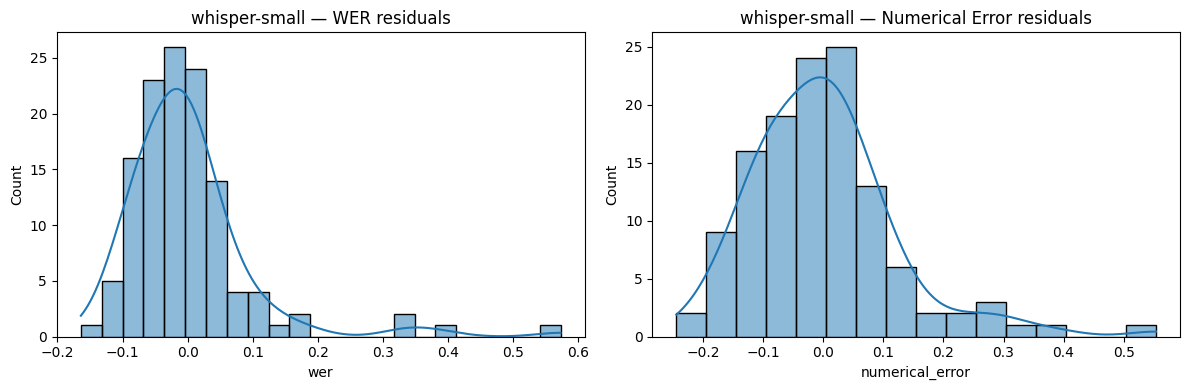


📊 Checking ANOVA assumptions for variant: whisper-large-v3-turbo
Shapiro-Wilk test for Normality (WER residuals):
  Statistic: 0.756, p-value: 0.0000
Shapiro-Wilk test for Normality (Numerical Error residuals):
  Statistic: 0.840, p-value: 0.0000
Levene’s test for equal variances (WER):
  Statistic: 2.292, p-value: 0.0397
Levene’s test for equal variances (Numerical Error):
  Statistic: 0.654, p-value: 0.6870


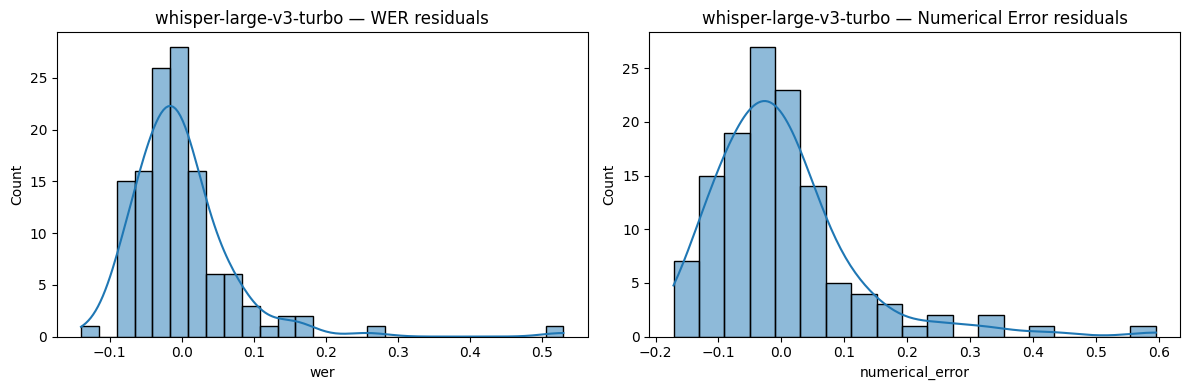


📊 Checking ANOVA assumptions for variant: GPT-4o mini Transcribe
Shapiro-Wilk test for Normality (WER residuals):
  Statistic: 0.744, p-value: 0.0000
Shapiro-Wilk test for Normality (Numerical Error residuals):
  Statistic: 0.900, p-value: 0.0000
Levene’s test for equal variances (WER):
  Statistic: 2.312, p-value: 0.0381
Levene’s test for equal variances (Numerical Error):
  Statistic: 0.708, p-value: 0.6438


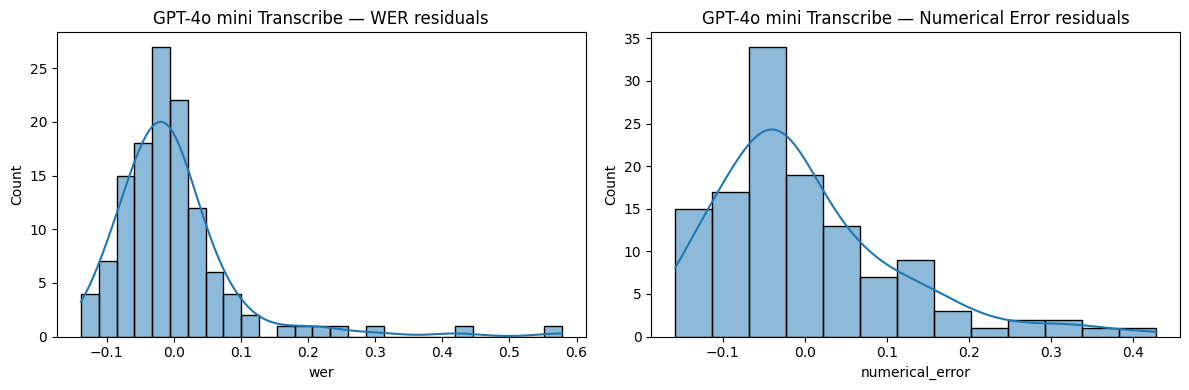

In [ ]:
#ANOVA AND WONT WORK
from scipy.stats import shapiro, levene

# Loop through each variant
for variant in df_22["variant"].unique():
    print(f"\n📊 Checking ANOVA assumptions for variant: {variant}")
    df_variant = df_22[df_22["variant"] == variant].dropna(subset=["Language Family"])
    
    # === GROUP DATA ===
    grouped_wer = [group["wer"].values for _, group in df_variant.groupby("Language Family")]
    grouped_num = [group["numerical_error"].values for _, group in df_variant.groupby("Language Family")]

    # === NORMALITY (Shapiro-Wilk test on residuals) ===
    print("Shapiro-Wilk test for Normality (WER residuals):")
    residuals_wer = df_variant["wer"] - df_variant.groupby("Language Family")["wer"].transform("mean")
    stat, p = shapiro(residuals_wer)
    print(f"  Statistic: {stat:.3f}, p-value: {p:.4f}")

    print("Shapiro-Wilk test for Normality (Numerical Error residuals):")
    residuals_num = df_variant["numerical_error"] - df_variant.groupby("Language Family")["numerical_error"].transform("mean")
    stat, p = shapiro(residuals_num)
    print(f"  Statistic: {stat:.3f}, p-value: {p:.4f}")

    # === HOMOGENEITY OF VARIANCES (Levene's test) ===
    print("Levene’s test for equal variances (WER):")
    stat, p = levene(*grouped_wer)
    print(f"  Statistic: {stat:.3f}, p-value: {p:.4f}")

    print("Levene’s test for equal variances (Numerical Error):")
    stat, p = levene(*grouped_num)
    print(f"  Statistic: {stat:.3f}, p-value: {p:.4f}")
    
    # Optional: Q-Q plots for visual inspection
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(residuals_wer, kde=True, ax=axes[0])
    axes[0].set_title(f"{variant} — WER residuals")
    sns.histplot(residuals_num, kde=True, ax=axes[1])
    axes[1].set_title(f"{variant} — Numerical Error residuals")
    plt.tight_layout()
    plt.show()
